In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sb
import matplotlib.pyplot as plt 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import sklearn.metrics.pairwise
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel 
from sklearn.feature_selection import RFE

In [3]:
heart = pd.read_csv("heart_2020_cleaned.csv")
heart.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

In [4]:
heart.isnull().any() #check for any null values

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

No     292422
Yes     27373
Name: HeartDisease, dtype: int64


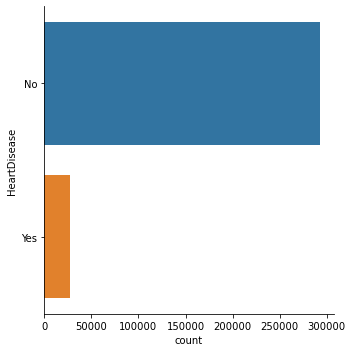

In [5]:
print(heart["HeartDisease"].value_counts())
sb.catplot(y = "HeartDisease", data = heart, kind = "count")

Visualizing the data on heart disease, highly biased towards no heart disease

In [6]:
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

In [7]:
heart.Diabetic.value_counts()

No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: Diabetic, dtype: int64

In [8]:
# Since we want to diagnose as Yes for heart-disease, even if there is a slightest chance, let us consider borderline diabetic and pregnancy diabetic as No.
heart['Diabetic'] = heart.Diabetic.apply(lambda x: 'No' if x == 'No, borderline diabetes' or x == 'Yes (during pregnancy)' else x)
heart.Diabetic.value_counts()

No     278993
Yes     40802
Name: Diabetic, dtype: int64

To separate the diabetes categories into two distinct group. In biology, pregenancy results in temporary diabetic symptom thus they are categories into the No grp

In [9]:
heart.isnull().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

# Visualizing the data

In [10]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [11]:
numerical = heart.select_dtypes(include=['float64'])
numerical.head()

BMI  PhysicalHealth  MentalHealth  SleepTime
0  16.60             3.0          30.0        5.0
1  20.34             0.0           0.0        7.0
2  26.58            20.0          30.0        8.0
3  24.21             0.0           0.0        6.0
4  23.71            28.0           0.0        8.0

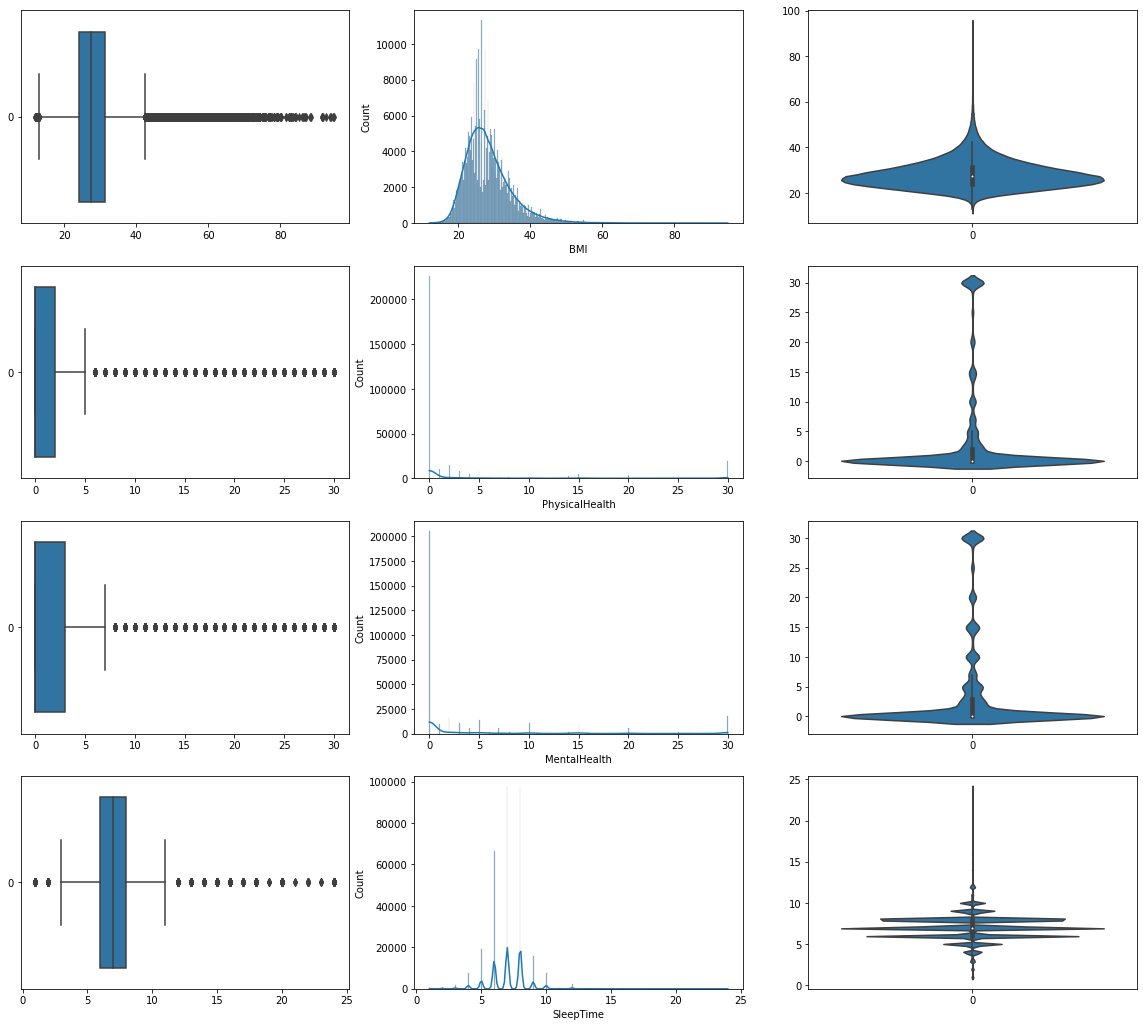

In [12]:
# Draw the distributions of all Predictors
f, axes = plt.subplots(4, 3, figsize=(20, 18))

count = 0
for var in numerical:
    sb.boxplot(data=numerical[var], orient = "h", ax = axes[count,0])
    sb.histplot(data=numerical[var], kde = True, ax = axes[count,1])
    sb.violinplot(data=numerical[var], ax = axes[count,2])
    count += 1

Visualization of numeric variables

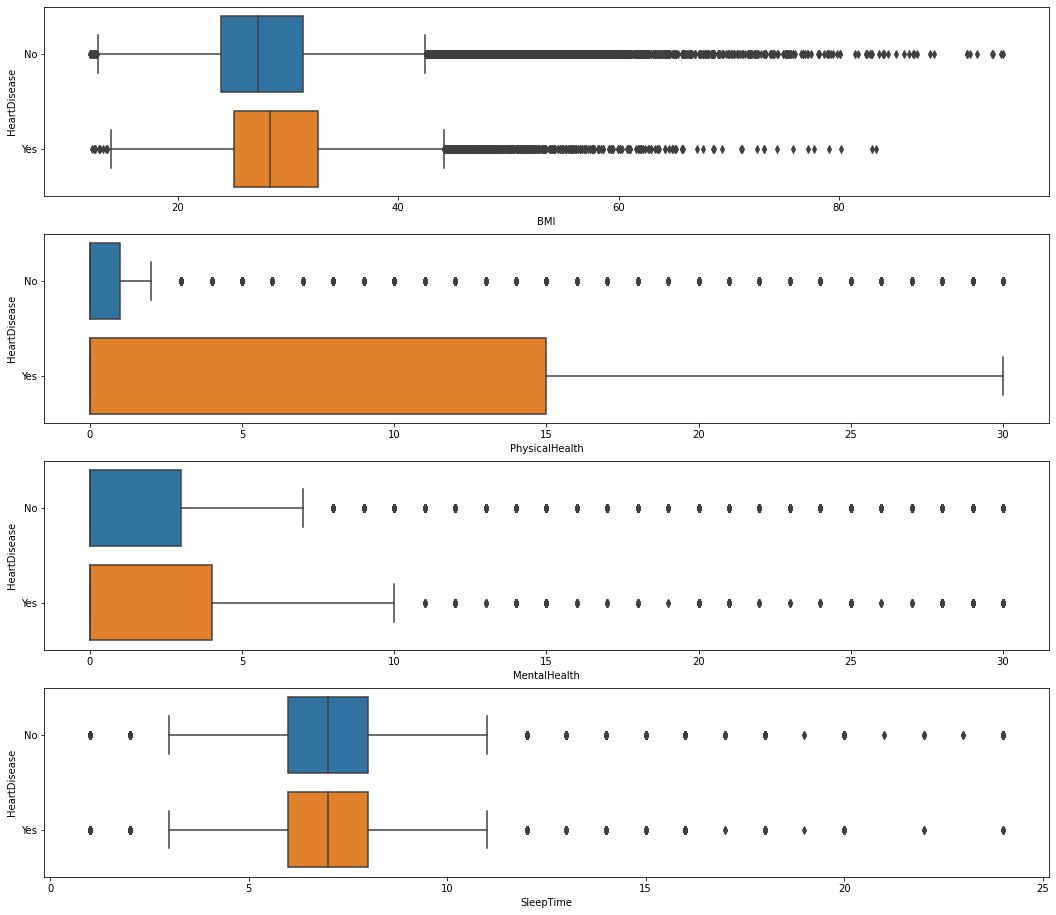

In [13]:
# Relationship between Response and the Predictors
trainDF = pd.concat([heart['HeartDisease'], numerical], axis = 1).reindex(heart['HeartDisease'].index)

f, axes = plt.subplots(4, 1, figsize=(18, 16))

count = 0
for var in numerical:
    sb.boxplot(x = var, y = "HeartDisease", data = trainDF, orient = "h", ax = axes[count])
    count += 1

The visualize the relations between the variable and heart disease outcome

In [14]:
catergorical = heart.select_dtypes(include=['object'])
catergorical_var = catergorical.drop(labels = 'HeartDisease', axis = 1)
catergorical_var.head()

Smoking AlcoholDrinking Stroke DiffWalking     Sex  AgeCategory   Race  \
0     Yes              No     No          No  Female        55-59  White   
1      No              No    Yes          No  Female  80 or older  White   
2     Yes              No     No          No    Male        65-69  White   
3      No              No     No          No  Female        75-79  White   
4      No              No     No         Yes  Female        40-44  White   

  Diabetic PhysicalActivity  GenHealth Asthma KidneyDisease SkinCancer  
0      Yes              Yes  Very good    Yes            No        Yes  
1       No              Yes  Very good     No            No         No  
2      Yes              Yes       Fair    Yes            No         No  
3       No               No       Good     No            No        Yes  
4       No              Yes  Very good     No            No         No

In [15]:
heart_sorted = heart.copy()
heart.sort_values(by=['AgeCategory'], inplace=True)

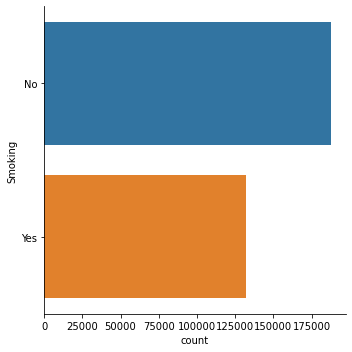

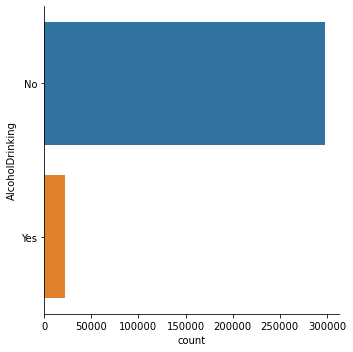

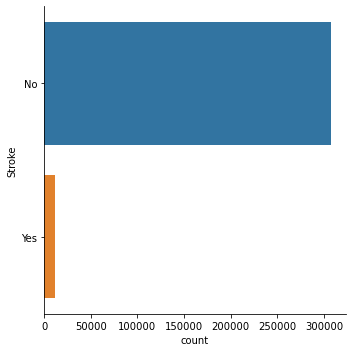

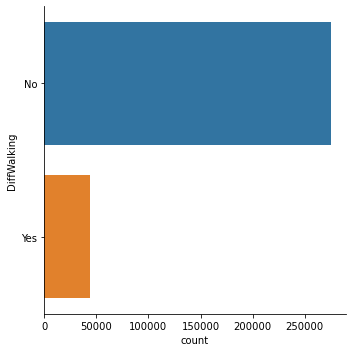

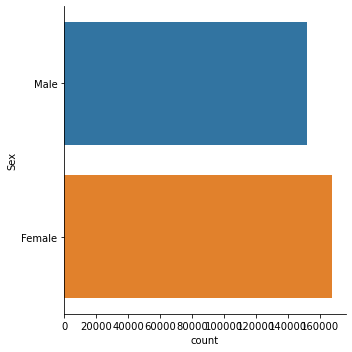

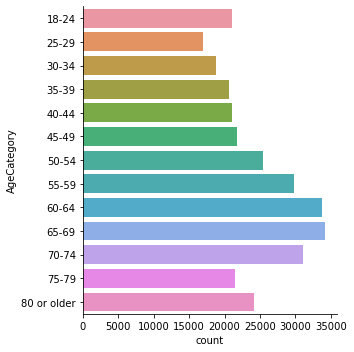

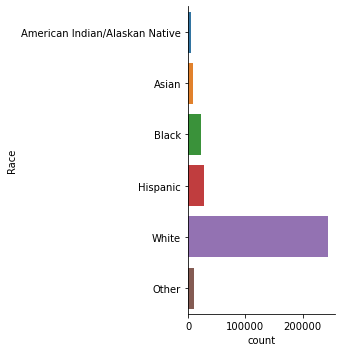

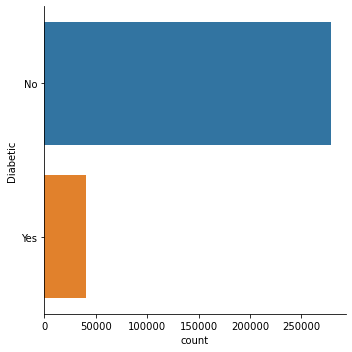

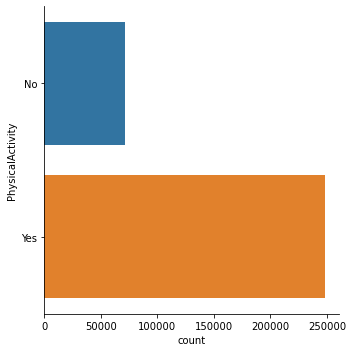

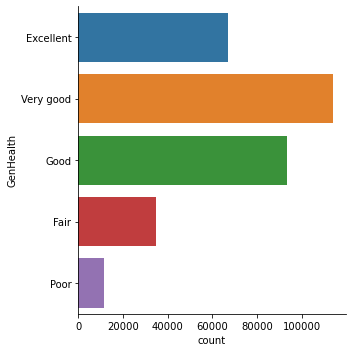

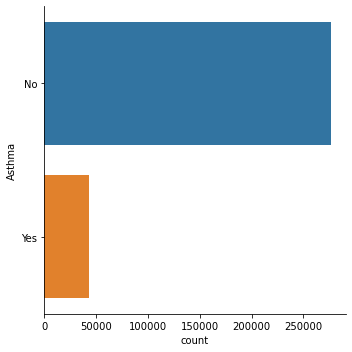

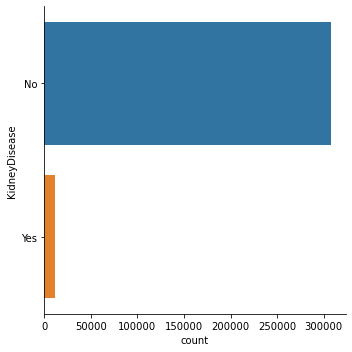

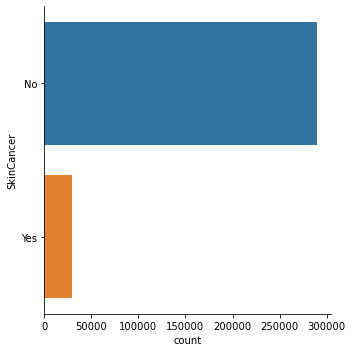

In [16]:
count = 0
for var in catergorical_var:
    if var == 'GenHealth':
        sb.catplot(y = var, data = heart, kind = "count", order = ['Excellent','Very good','Good','Fair','Poor'])
    elif var == 'Race':
        sb.catplot(y = var, data = heart, kind = "count", order = ['American Indian/Alaskan Native','Asian','Black','Hispanic','White','Other'])
    elif var == 'PhysicalActivity':
        sb.catplot(y = var, data = heart, kind = "count", order = ['No','Yes'])
    else:
        sb.catplot(y = var, data = heart, kind = "count")
    count += 1

Visualizing the categorical variables, many variable have poor ratio

# Data Preparation

Since the dataset is a mixed of categorical and numerical variable, the categorical variable needed to be converted to numbers for machine learning algorithms

In [17]:
Y = heart['HeartDisease']
Y.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [18]:
# Notice that we have a few categorical variables with Yes/No values. Let us convert them to binary 1/0
column_yesno = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

heart[column_yesno] = heart[column_yesno].apply(lambda x: x.map({'Yes':1,'No':0}))
heart.head()

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
289336             0  21.83        0                0       0            20.0   
92977              0  21.14        0                0       0             0.0   
228704             0  20.81        0                0       0             0.0   
49749              0  20.84        1                0       0             0.0   
49753              0  24.33        0                0       0             0.0   

        MentalHealth  DiffWalking     Sex AgeCategory      Race  Diabetic  \
289336           8.0            0    Male       18-24     Other         0   
92977            0.0            0  Female       18-24     White         0   
228704          10.0            0  Female       18-24     White         0   
49749            3.0            0    Male       18-24     Asian         0   
49753            0.0            0    Male       18-24  Hispanic         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
289336                 1  Excellent        8.0       0              0   
92977                  1  Excellent        9.0       0              0   
228704                 1  Excellent        7.0       1              0   
49749                  0       Good       10.0       0              0   
49753                  1  Excellent        7.0       0              0   

        SkinCancer  
289336           0  
92977            0  
228704           0  
49749            0  
49753            0

For machine learning, the categorical variable are converted to numeric (0 and 1). In this case, 1 indicate for yes and 0 for no

In [19]:
heart.info()
heart_orig = heart.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319795 entries, 289336 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  int64  
 16  KidneyDisease  

In [20]:
# We can find 4 more categorical variables which are not yes/no. The dtype is object for these 4. Let us convert them into dummy variables.
categoricals = heart.select_dtypes(include=['object'])
cat_dummies = pd.get_dummies(categoricals, drop_first=False) #drop heartdisease
 
# Drop the redundant columns
heart.drop(list(categoricals.columns), axis=1, inplace=True) #removed all variables in dummies
# concat the heart and dummies data frames.
heart = pd.concat([heart, cat_dummies], axis=1)
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319795 entries, 289336 to 319794
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   HeartDisease                         319795 non-null  int64  
 1   BMI                                  319795 non-null  float64
 2   Smoking                              319795 non-null  int64  
 3   AlcoholDrinking                      319795 non-null  int64  
 4   Stroke                               319795 non-null  int64  
 5   PhysicalHealth                       319795 non-null  float64
 6   MentalHealth                         319795 non-null  float64
 7   DiffWalking                          319795 non-null  int64  
 8   Diabetic                             319795 non-null  int64  
 9   PhysicalActivity                     319795 non-null  int64  
 10  SleepTime                            319795 non-null  float64
 11  Asthma  

Remaining categorical variables are also converted by a dummie variable (Could also use OneHotEncoder tho result would be roughly the same)

In [21]:
heart.head()

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
289336             0  21.83        0                0       0            20.0   
92977              0  21.14        0                0       0             0.0   
228704             0  20.81        0                0       0             0.0   
49749              0  20.84        1                0       0             0.0   
49753              0  24.33        0                0       0             0.0   

        MentalHealth  DiffWalking  Diabetic  PhysicalActivity  ...  \
289336           8.0            0         0                 1  ...   
92977            0.0            0         0                 1  ...   
228704          10.0            0         0                 1  ...   
49749            3.0            0         0                 0  ...   
49753            0.0            0         0                 1  ...   

        Race_Asian  Race_Black  Race_Hispanic  Race_Other  Race_White  \
289336           0           0              0           1           0   
92977            0           0              0           0           1   
228704           0           0              0           0           1   
49749            1           0              0           0           0   
49753            0           0              1           0           0   

        GenHealth_Excellent  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
289336                    1               0               0               0   
92977                     1               0               0               0   
228704                    1               0               0               0   
49749                     0               0               1               0   
49753                     1               0               0               0   

        GenHealth_Very good  
289336                    0  
92977                     0  
228704                    0  
49749                     0  
49753                     0  

[5 rows x 40 columns]

In [22]:
# Here we are interested in the chance of having the heart disease based on other variables.
# Let y be HeartDisease column
y = heart.pop('HeartDisease')
X = heart
X.head()

BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  MentalHealth  \
289336  21.83        0                0       0            20.0           8.0   
92977   21.14        0                0       0             0.0           0.0   
228704  20.81        0                0       0             0.0          10.0   
49749   20.84        1                0       0             0.0           3.0   
49753   24.33        0                0       0             0.0           0.0   

        DiffWalking  Diabetic  PhysicalActivity  SleepTime  ...  Race_Asian  \
289336            0         0                 1        8.0  ...           0   
92977             0         0                 1        9.0  ...           0   
228704            0         0                 1        7.0  ...           0   
49749             0         0                 0       10.0  ...           1   
49753             0         0                 1        7.0  ...           0   

        Race_Black  Race_Hispanic  Race_Other  Race_White  \
289336           0              0           1           0   
92977            0              0           0           1   
228704           0              0           0           1   
49749            0              0           0           0   
49753            0              1           0           0   

        GenHealth_Excellent  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
289336                    1               0               0               0   
92977                     1               0               0               0   
228704                    1               0               0               0   
49749                     0               0               1               0   
49753                     1               0               0               0   

        GenHealth_Very good  
289336                    0  
92977                     0  
228704                    0  
49749                     0  
49753                     0  

[5 rows x 39 columns]

In [23]:
X.shape,Y.shape

((319795, 39), (319795,))

# Data Imbalance

In [24]:
import sklearn.metrics.pairwise
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

In [25]:
rus = RandomUnderSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, Y)

In [26]:
X_res.shape

(54746, 39)

In [27]:
print(y_res.value_counts())

No     27373
Yes    27373
Name: HeartDisease, dtype: int64


In [28]:
Balance = pd.concat([y_res,X_res],axis=1)
Balance

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0               No  25.04        0                0       0             0.0   
1               No  20.38        0                0       0             0.0   
2               No  29.12        0                0       0             0.0   
3               No  20.60        0                0       0             0.0   
4               No  20.34        1                0       0             0.0   
...            ...    ...      ...              ...     ...             ...   
54741          Yes  25.09        0                0       0            30.0   
54742          Yes  30.71        1                0       0             5.0   
54743          Yes  29.01        0                0       0             0.0   
54744          Yes  23.06        1                0       0             0.0   
54745          Yes  20.92        1                0       0             0.0   

       MentalHealth  DiffWalking  Diabetic  PhysicalActivity  ...  Race_Asian  \
0               3.0            0         0                 1  ...           0   
1               1.0            0         0                 1  ...           0   
2              30.0            0         0                 1  ...           0   
3               0.0            0         0                 1  ...           0   
4               0.0            0         0                 1  ...           0   
...             ...          ...       ...               ...  ...         ...   
54741           0.0            1         1                 1  ...           0   
54742           3.0            1         1                 1  ...           0   
54743           0.0            0         0                 1  ...           0   
54744           0.0            0         0                 1  ...           0   
54745           0.0            0         0                 1  ...           0   

       Race_Black  Race_Hispanic  Race_Other  Race_White  GenHealth_Excellent  \
0               0              0           0           1                    0   
1               0              0           0           1                    0   
2               0              0           0           1                    1   
3               0              1           0           0                    0   
4               0              0           0           1                    1   
...           ...            ...         ...         ...                  ...   
54741           0              0           0           1                    0   
54742           0              0           0           1                    0   
54743           0              0           0           1                    0   
54744           0              0           0           1                    0   
54745           0              0           0           1                    0   

       GenHealth_Fair  GenHealth_Good  GenHealth_Poor  GenHealth_Very good  
0                   0               0               0                    1  
1                   0               0               0                    1  
2                   0               0               0                    0  
3                   0               0               0                    1  
4                   0               0               0                    0  
...               ...             ...             ...                  ...  
54741               0               0               1                    0  
54742               0               1               0                    0  
54743               0               1               0                    0  
54744               0               1               0                    0  
54745               1               0               0                    0  

[54746 rows x 40 columns]

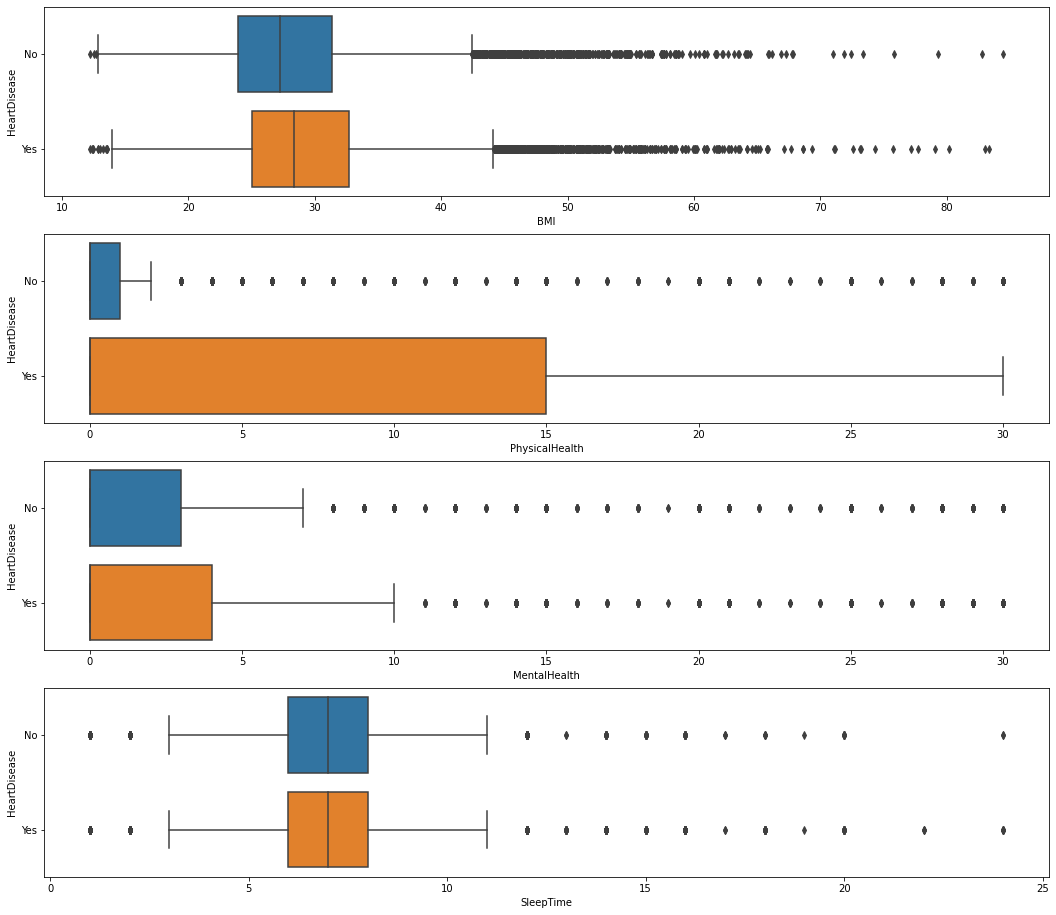

In [29]:
f, axes = plt.subplots(4, 1, figsize=(18, 16))

count = 0
for var in numerical:
    sb.boxplot(x = var, y = "HeartDisease", data = Balance, orient = "h", ax = axes[count])
    count += 1

In [30]:
Balance2 = Balance.copy()
Balance2 = Balance2.drop(labels=numerical,axis=1)
Balance2_col = Balance2.columns

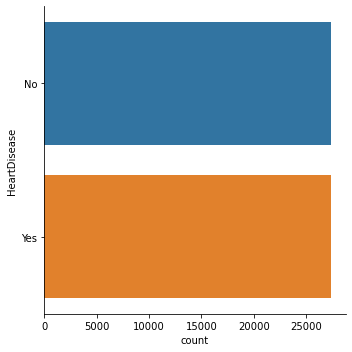

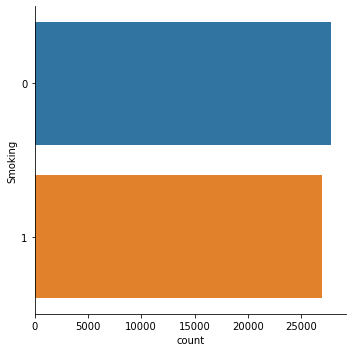

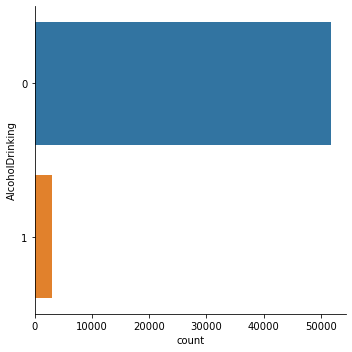

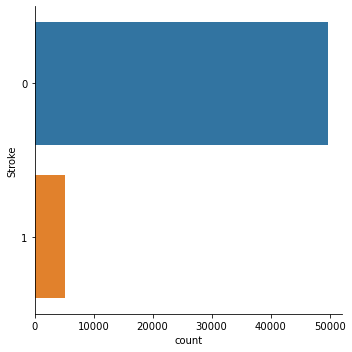

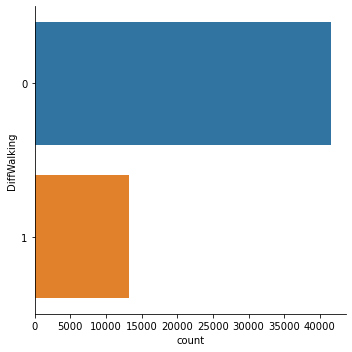

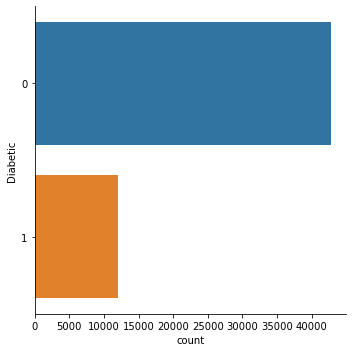

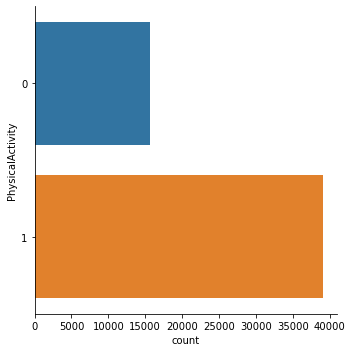

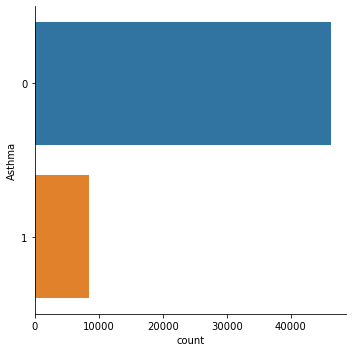

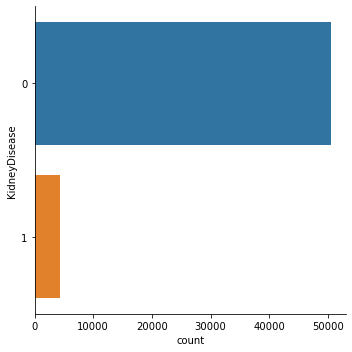

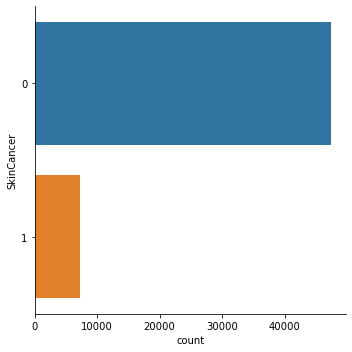

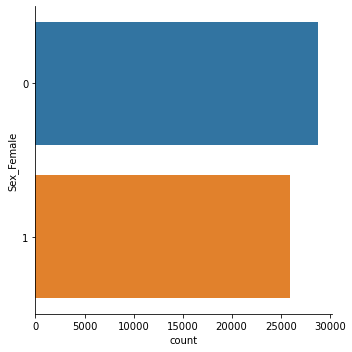

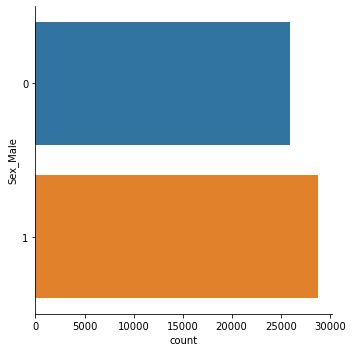

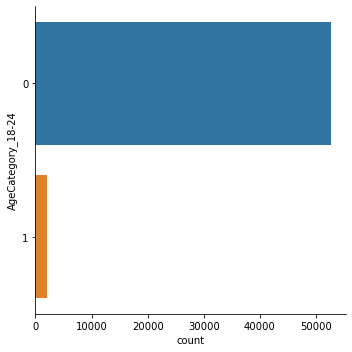

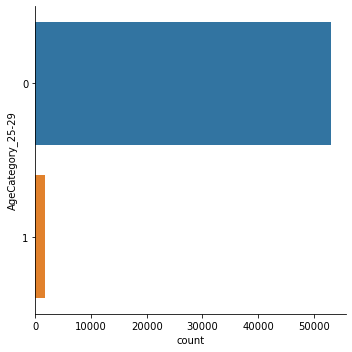

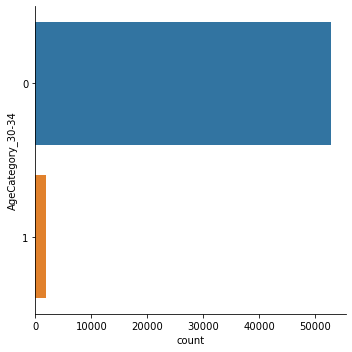

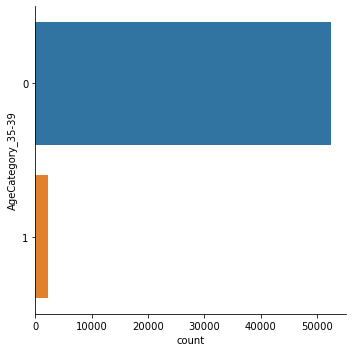

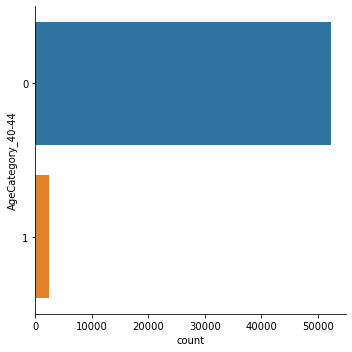

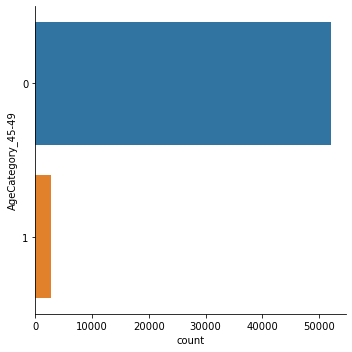

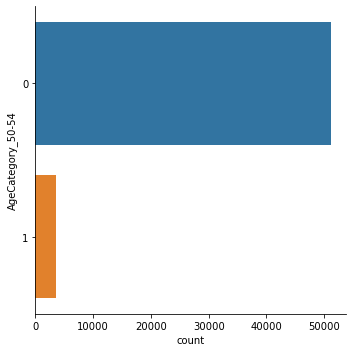

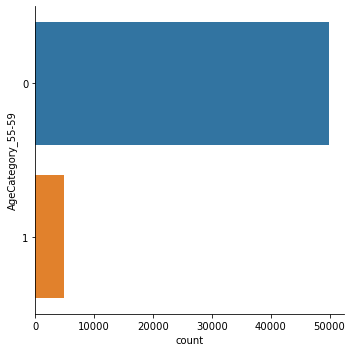

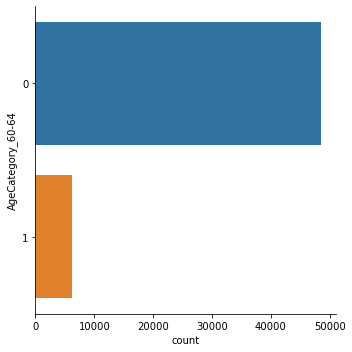

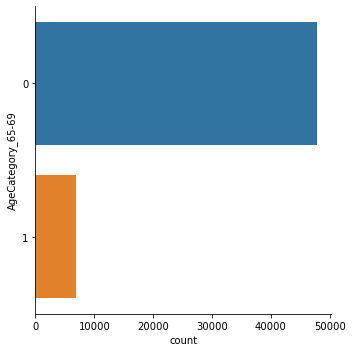

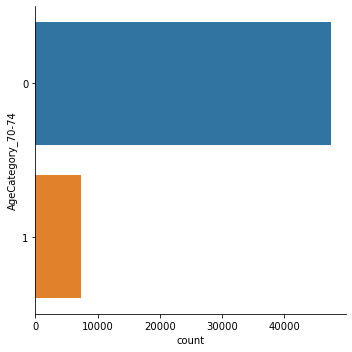

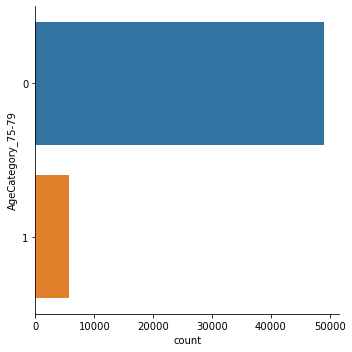

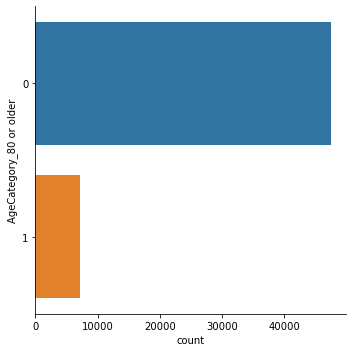

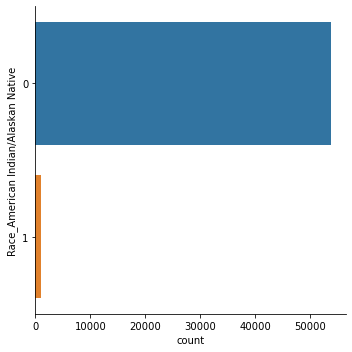

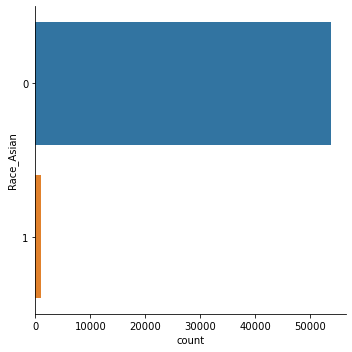

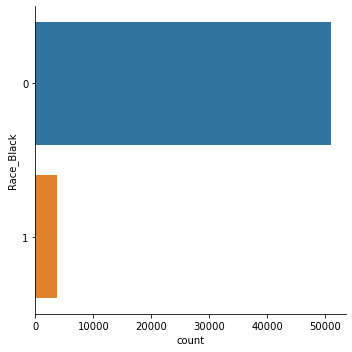

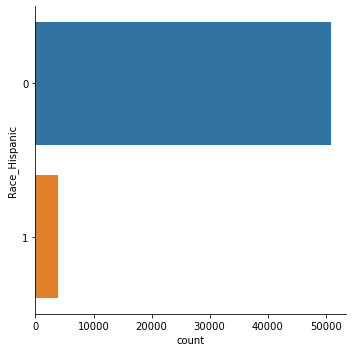

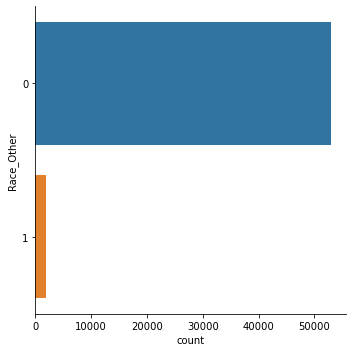

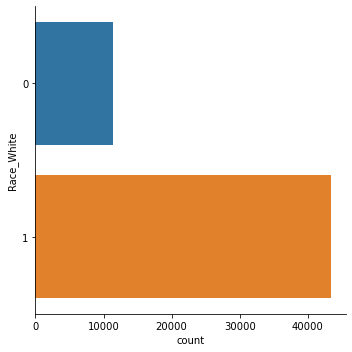

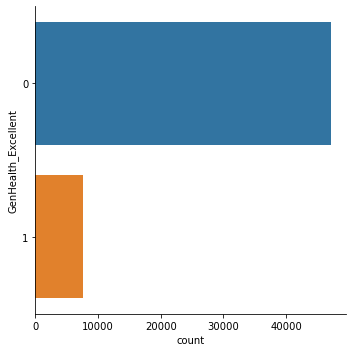

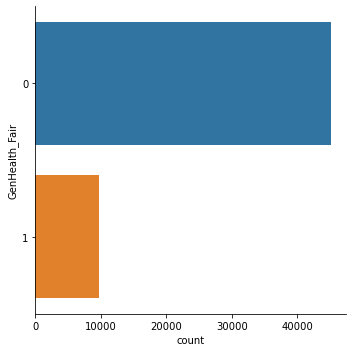

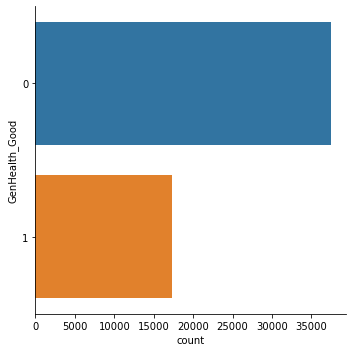

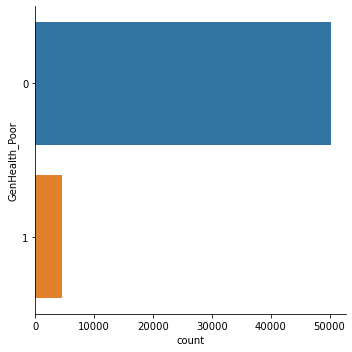

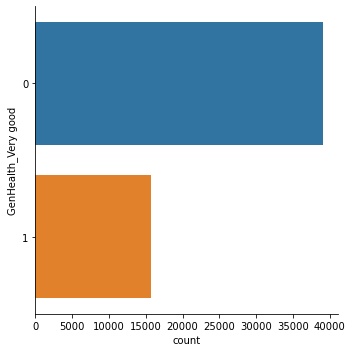

In [31]:
count = 0
for var in Balance2_col:
    sb.catplot(y = var, data = Balance, kind = "count")
    count += 1

In [32]:
y_res = pd.DataFrame({'HeartDisease': y_res})
y_res2 = y_res.copy()

In [33]:
column_yesno2 = ["HeartDisease"]

y_res2[column_yesno2] = y_res2[column_yesno2].apply(lambda x: x.map({'Yes':1,'No':0}))
y_res2.head(10)

HeartDisease
0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0

As the heart disease is highly biased towards 'No', we decided to undersample the data to have equal amount of 'Yes' and 'No'. Of course, oversampling using SMOTE could also work, but that uses a mathematical calculation to derive a new synthethic data

Now we would like to ask ourselve if a person lifestyle habits or the person preexisting medical condition play a bigger role in the likelihood of them developing heart disease

# Decision Tree

# Lifestyle - With imbalance data

In [34]:
Lifestyle = heart[['BMI','Smoking','AlcoholDrinking','PhysicalActivity','SleepTime']]
Lifestyle.head()

BMI  Smoking  AlcoholDrinking  PhysicalActivity  SleepTime
289336  21.83        0                0                 1        8.0
92977   21.14        0                0                 1        9.0
228704  20.81        0                0                 1        7.0
49749   20.84        1                0                 0       10.0
49753   24.33        0                0                 1        7.0

In [35]:
Lifestyle_table = pd.concat([y,Lifestyle],axis=1)
Lifestyle_table

HeartDisease    BMI  Smoking  AlcoholDrinking  PhysicalActivity  \
289336             0  21.83        0                0                 1   
92977              0  21.14        0                0                 1   
228704             0  20.81        0                0                 1   
49749              0  20.84        1                0                 0   
49753              0  24.33        0                0                 1   
...              ...    ...      ...              ...               ...   
261373             0  30.23        1                0                 1   
203667             0  25.83        0                0                 1   
261380             1  20.92        1                0                 1   
261449             0  22.31        0                0                 0   
319794             0  46.56        0                0                 1   

        SleepTime  
289336        8.0  
92977         9.0  
228704        7.0  
49749        10.0  
49753         7.0  
...           ...  
261373       10.0  
203667        7.0  
261380        8.0  
261449        9.0  
319794        8.0  

[319795 rows x 6 columns]

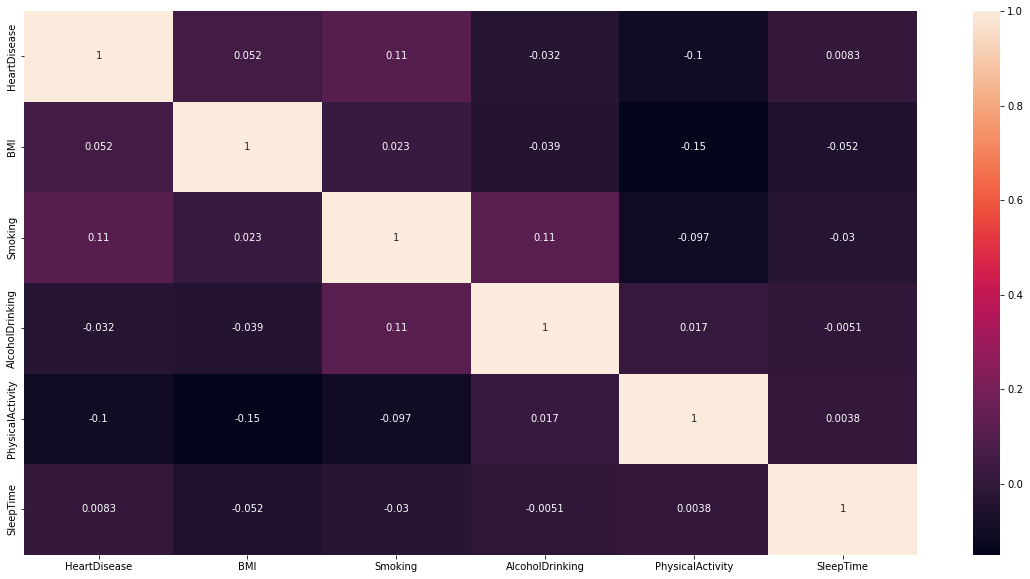

In [36]:
plt.figure(figsize = (20,10))
sb.heatmap(Lifestyle_table.corr(),annot = True)
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle, y, train_size=0.7, test_size=0.3, random_state=100)
print("Train Set :", HD1_train.shape, LS_train.shape)
print("Test Set  :", HD1_test.shape, LS_test.shape)

Train Set : (223856,) (223856, 5)
Test Set  : (95939,) (95939, 5)


In [38]:
HD1_train.value_counts()

0    204733
1     19123
Name: HeartDisease, dtype: int64

In [39]:
HD1_test.value_counts()

0    87689
1     8250
Name: HeartDisease, dtype: int64

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

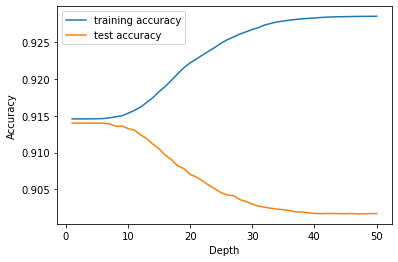

In [41]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 51) 
for var in neighbors_settings: # build the model 
    dectree = DecisionTreeClassifier(max_depth = var) 
    dectree.fit(LS_train, HD1_train) # record training set accuracy 
    training_accuracy.append(dectree.score(LS_train, HD1_train)) # record generalization accuracy 
    test_accuracy.append(dectree.score(LS_test, HD1_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("Depth") 
plt.legend()

As the data is highly bias towards no heart disease and little changes is observed with increasing depth, a depth of 4 was choosen to avoid overfitting - where the model is too complex with train data and unable to predict test data well

In [42]:
# Train the Decision Tree Classifier model
dectree = DecisionTreeClassifier(max_depth = 4)
dectree.fit(LS_train, HD1_train)

DecisionTreeClassifier(max_depth=4)

[Text(0.5, 0.9, 'Smoking <= 0.5\ngini = 0.156\nsamples = 223856\nvalue = [204733, 19123]\nclass = No'),
 Text(0.25, 0.7, 'PhysicalActivity <= 0.5\ngini = 0.113\nsamples = 131559\nvalue = [123614, 7945]\nclass = No'),
 Text(0.125, 0.5, 'SleepTime <= 4.5\ngini = 0.182\nsamples = 25104\nvalue = [22570, 2534]\nclass = No'),
 Text(0.0625, 0.3, 'BMI <= 33.58\ngini = 0.307\nsamples = 1191\nvalue = [965, 226]\nclass = No'),
 Text(0.03125, 0.1, 'gini = 0.28\nsamples = 772\nvalue = [642, 130]\nclass = No'),
 Text(0.09375, 0.1, 'gini = 0.353\nsamples = 419\nvalue = [323, 96]\nclass = No'),
 Text(0.1875, 0.3, 'BMI <= 26.635\ngini = 0.174\nsamples = 23913\nvalue = [21605, 2308]\nclass = No'),
 Text(0.15625, 0.1, 'gini = 0.144\nsamples = 8432\nvalue = [7775, 657]\nclass = No'),
 Text(0.21875, 0.1, 'gini = 0.191\nsamples = 15481\nvalue = [13830, 1651]\nclass = No'),
 Text(0.375, 0.5, 'BMI <= 25.185\ngini = 0.096\nsamples = 106455\nvalue = [101044, 5411]\nclass = No'),
 Text(0.3125, 0.3, 'SleepTime <=

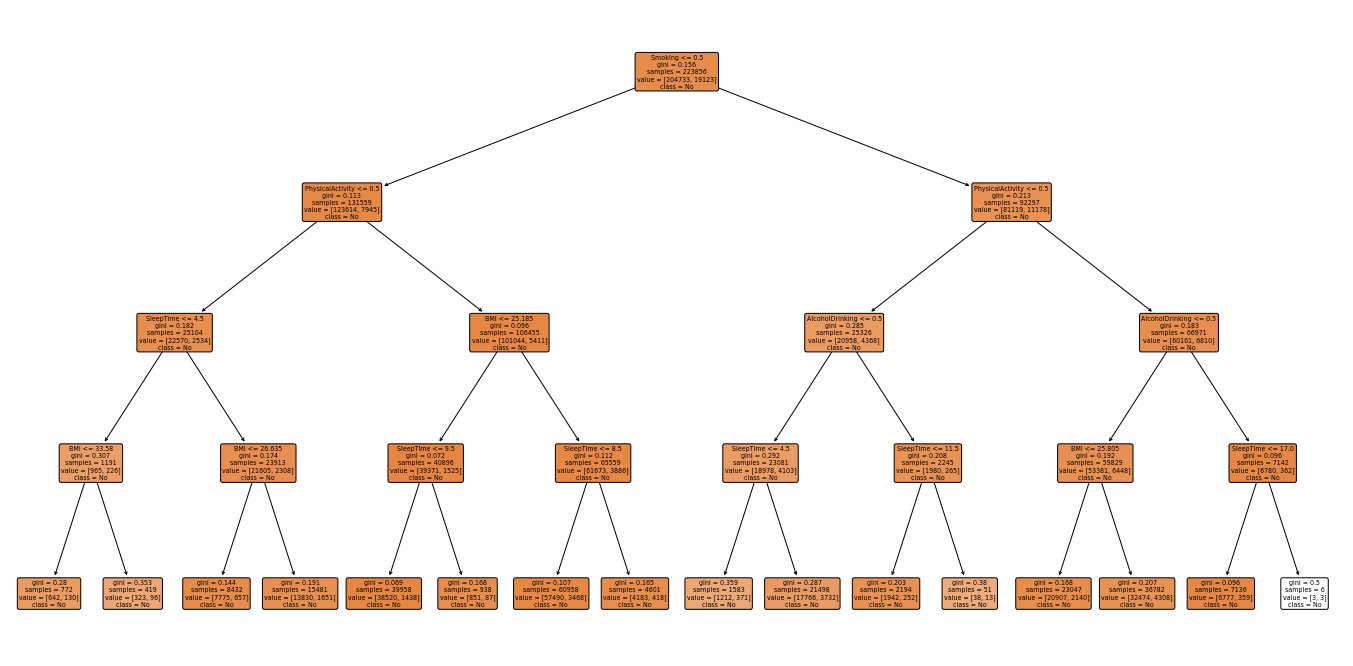

In [43]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(24,12))
plot_tree(dectree, filled=True, rounded=True, feature_names=['BMI','Smoking','AlcoholDrinking','PhysicalActivity','SleepTime'], class_names=["No","Yes"])

Classification Accuracy 	: 0.9145745479236652


Text(33.0, 0.5, 'True Value')

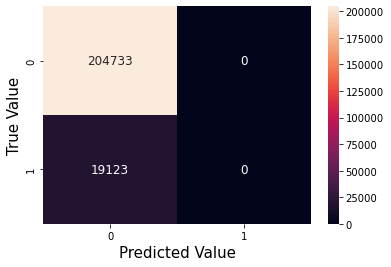

In [44]:
# Predict Legendary corresponding to Total Train
# Remember: training set is to be used as the input argument to the decision tree classifier.
HD1_train_pred = dectree.predict(LS_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [45]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
DTLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
DTLS_Spec = TN / float(TN+FP)
#Precision
DTLS_Prec = TP/ float(TP+FP)
# Accuracy
DTLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
DTLS_f = 2*((DTLS_Sen*DTLS_Prec)/(DTLS_Prec+DTLS_Sen))
#False Positive Rate
DTLS_FPR = FP/ float(TN+FP)
#False Negative Rate
DTLS_FNR = FN/ float(TP+FN)

DT_Train_result_un = {'Algorithm ': ['Decision Tree'],'Sensitivity ': [DTLS_Sen], 'Specificity': [DTLS_Spec],'Precision ': [DTLS_Prec],'Accuracy': [DTLS_Acc], 'F-score': [DTLS_f],'FPR ': [DTLS_FPR], 'FNR': [DTLS_FNR]}
DT_Train_un = pd.DataFrame(DT_Train_result_un)
DT_Train_un

Algorithm   Sensitivity   Specificity  Precision   Accuracy  F-score  \
0  Decision Tree           0.0          1.0         NaN  0.914575      NaN   

   FPR   FNR  
0   0.0  1.0

Sensitivty - Measure how many of the positive samples are captured by the positive prediction 

Specificity - Measure how many of the negative samples are captured by the negative prediction 

Precision - How many of the samples predicted as positive are actually positive

Accuracy - Number of correct prediction divided by the number of all samples

F-Score - Accuracy which take into the account of the precision and the recall/sensitivty

False Positive Rate - Test result incorrectly indicates the presence of a condition (such as a disease when the disease is not present)

False Negative Rate - Where the test result incorrectly indicates the absence of a condition when it is actually present.

Classification Accuracy 	: 0.9140078591605082


Text(33.0, 0.5, 'True Value')

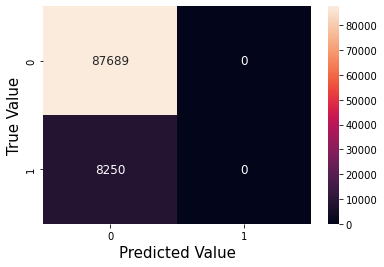

In [46]:
HD1_test_pred = dectree.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [47]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
DTLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
DTLS_Spec = TN / float(TN+FP)
#Precision
DTLS_Prec = TP/ float(TP+FP)
# Accuracy
DTLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
DTLS_f = 2*((DTLS_Sen*DTLS_Prec)/(DTLS_Prec+DTLS_Sen))
#False Positive Rate
DTLS_FPR = FP/ float(TN+FP)
#False Negative Rate
DTLS_FNR = FN/ float(TP+FN)

DTLS_result_un = [DTLS_Sen,DTLS_Spec,DTLS_Prec,DTLS_Acc,DTLS_f,DTLS_FPR,DTLS_FNR]

DT_Test_result_un = {'Algorithm ': ['Decision Tree'],'Sensitivity ': [DTLS_Sen], 'Specificity': [DTLS_Spec],'Precision ': [DTLS_Prec],'Accuracy': [DTLS_Acc], 'F-score': [DTLS_f],'FPR ': [DTLS_FPR], 'FNR': [DTLS_FNR]}
DT_Test_un = pd.DataFrame(DT_Test_result_un)
DT_Test_un

Algorithm   Sensitivity   Specificity  Precision   Accuracy  F-score  \
0  Decision Tree           0.0          1.0         NaN  0.914008      NaN   

   FPR   FNR  
0   0.0  1.0

From the evaluation of the model, it has a very low sensitivity and low precision with high specificity. This means that the model are predicting data with 'No' heart disease well, but unable to predicit data with 'Yes' for heart disease.

# Decision Tree with Balanced data

In [48]:
Lifestyle_bal = X_res[['BMI','Smoking','AlcoholDrinking','PhysicalActivity','SleepTime']]
Lifestyle_bal.head()

BMI  Smoking  AlcoholDrinking  PhysicalActivity  SleepTime
0  25.04        0                0                 1        4.0
1  20.38        0                0                 1        8.0
2  29.12        0                0                 1        5.0
3  20.60        0                0                 1        5.0
4  20.34        1                0                 1        7.0

In [49]:
Lifestyle_table2 = pd.concat([y_res2,Lifestyle_bal],axis=1)
Lifestyle_table2

HeartDisease    BMI  Smoking  AlcoholDrinking  PhysicalActivity  \
0                 0  25.04        0                0                 1   
1                 0  20.38        0                0                 1   
2                 0  29.12        0                0                 1   
3                 0  20.60        0                0                 1   
4                 0  20.34        1                0                 1   
...             ...    ...      ...              ...               ...   
54741             1  25.09        0                0                 1   
54742             1  30.71        1                0                 1   
54743             1  29.01        0                0                 1   
54744             1  23.06        1                0                 1   
54745             1  20.92        1                0                 1   

       SleepTime  
0            4.0  
1            8.0  
2            5.0  
3            5.0  
4            7.0  
...          ...  
54741       10.0  
54742        7.0  
54743        6.0  
54744        8.0  
54745        8.0  

[54746 rows x 6 columns]

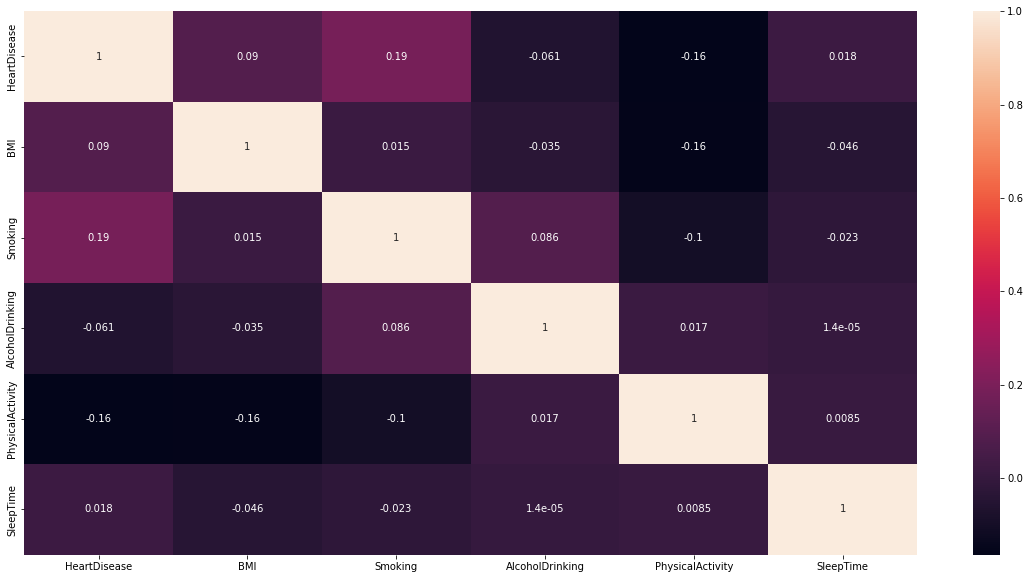

In [50]:
plt.figure(figsize = (20,10))
sb.heatmap(Lifestyle_table2.corr(),annot = True)
plt.show()

In [51]:
Lifestyle_bal.shape

(54746, 5)

In [52]:
Lifestyle.shape

(319795, 5)

In [53]:
from sklearn.model_selection import train_test_split
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle_bal, y_res, train_size=0.7, test_size=0.3, random_state=100)
print("Train Set :", HD1_train.shape, LS_train.shape)
print("Test Set  :", HD1_test.shape, LS_test.shape)

Train Set : (38322, 1) (38322, 5)
Test Set  : (16424, 1) (16424, 5)


In [54]:
HD1_train.value_counts()

HeartDisease
No              19180
Yes             19142
dtype: int64

In [55]:
HD1_test.value_counts()

HeartDisease
Yes             8231
No              8193
dtype: int64

In [56]:
dectree = DecisionTreeClassifier()
dectree.fit(LS_train, HD1_train)

print("Accuracy on training set: {:.3f}".format(dectree.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(dectree.score(LS_test, HD1_test)))

Accuracy on training set: 0.789
Accuracy on test set: 0.562


Overfitting using default setting

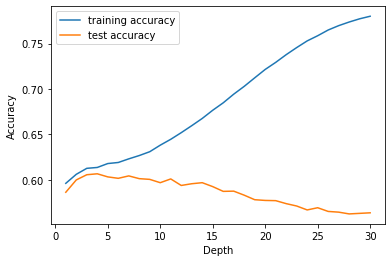

In [57]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 31) 
for var in neighbors_settings: # build the model 
    dectree = DecisionTreeClassifier(max_depth = var) 
    dectree.fit(LS_train, HD1_train) # record training set accuracy 
    training_accuracy.append(dectree.score(LS_train, HD1_train)) # record generalization accuracy 
    test_accuracy.append(dectree.score(LS_test, HD1_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("Depth") 
plt.legend()

In [58]:
# Train the Decision Tree Classifier model
dectree = DecisionTreeClassifier(max_depth = 5)
dectree.fit(LS_train, HD1_train)

DecisionTreeClassifier(max_depth=5)

[Text(0.5145833333333333, 0.9166666666666666, 'Smoking <= 0.5\ngini = 0.5\nsamples = 38322\nvalue = [19180, 19142]\nclass = No'),
 Text(0.26666666666666666, 0.75, 'PhysicalActivity <= 0.5\ngini = 0.482\nsamples = 19360\nvalue = [11531, 7829]\nclass = No'),
 Text(0.13333333333333333, 0.5833333333333334, 'SleepTime <= 4.5\ngini = 0.497\nsamples = 4657\nvalue = [2138, 2519]\nclass = Yes'),
 Text(0.06666666666666667, 0.4166666666666667, 'BMI <= 36.48\ngini = 0.403\nsamples = 300\nvalue = [84, 216]\nclass = Yes'),
 Text(0.03333333333333333, 0.25, 'BMI <= 34.95\ngini = 0.434\nsamples = 223\nvalue = [71, 152]\nclass = Yes'),
 Text(0.016666666666666666, 0.08333333333333333, 'gini = 0.418\nsamples = 208\nvalue = [62, 146]\nclass = Yes'),
 Text(0.05, 0.08333333333333333, 'gini = 0.48\nsamples = 15\nvalue = [9, 6]\nclass = No'),
 Text(0.1, 0.25, 'BMI <= 57.745\ngini = 0.281\nsamples = 77\nvalue = [13, 64]\nclass = Yes'),
 Text(0.08333333333333333, 0.08333333333333333, 'gini = 0.253\nsamples = 74\

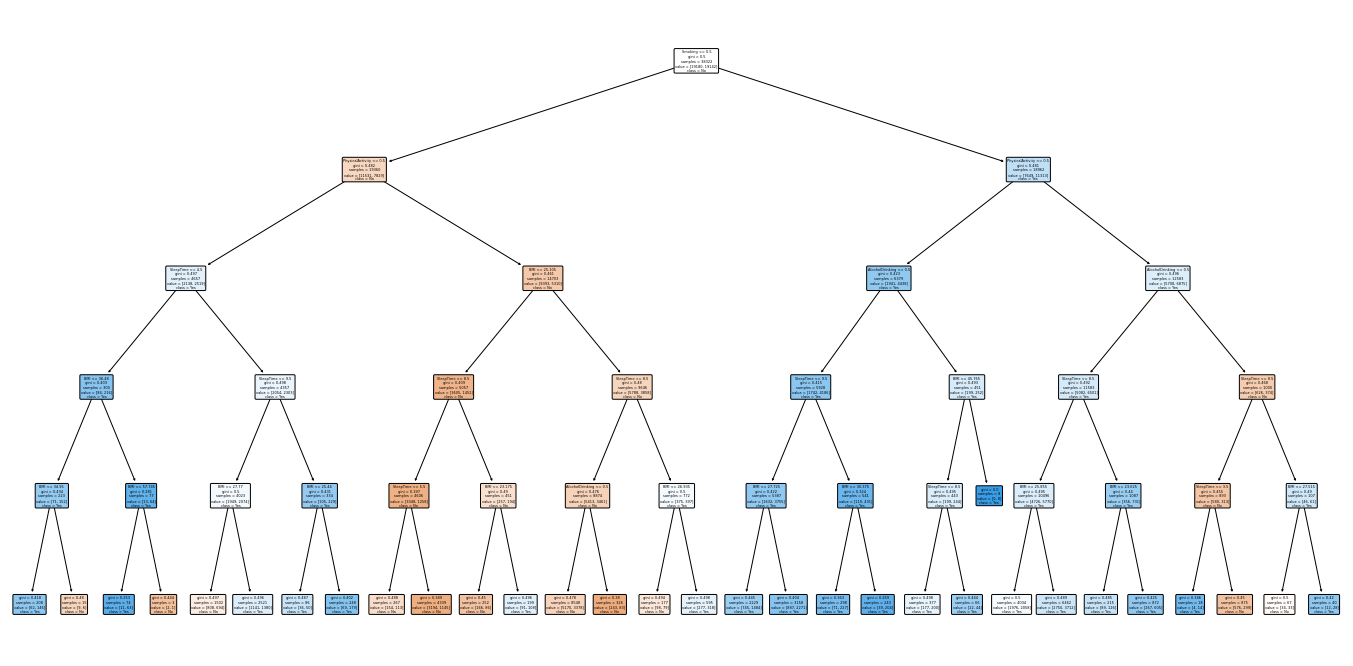

In [59]:
# Plot the trained Decision Tree
#from sklearn.tree import plot_tree

f = plt.figure(figsize=(24,12))
plot_tree(dectree, filled=True, rounded=True, feature_names=['BMI','Smoking','AlcoholDrinking','PhysicalActivity','SleepTime'], class_names=["No","Yes"])

Classification Accuracy 	: 0.6178957256928135


Text(33.0, 0.5, 'True Value')

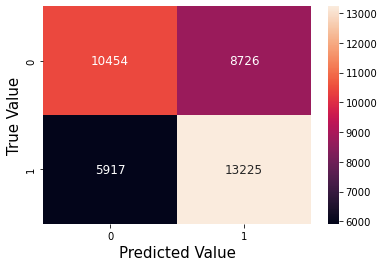

In [60]:
HD1_train_pred = dectree.predict(LS_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.6032026302971262


Text(33.0, 0.5, 'True Value')

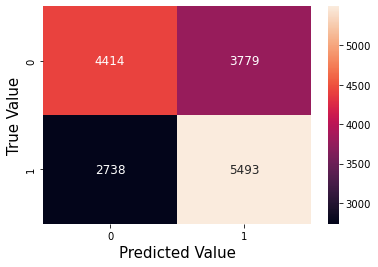

In [61]:
HD1_test_pred = dectree.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [62]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
DTLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
DTLS_Spec = TN / float(TN+FP)
#Precision
DTLS_Prec = TP/ float(TP+FP)
# Accuracy
DTLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
DTLS_f = 2*((DTLS_Sen*DTLS_Prec)/(DTLS_Prec+DTLS_Sen))
#False Positive Rate
DTLS_FPR = FP/ float(TN+FP)
#False Negative Rate
DTLS_FNR = FN/ float(TP+FN)

DTLS_result = [DTLS_Sen,DTLS_Spec,DTLS_Prec,DTLS_Acc,DTLS_f,DTLS_FPR,DTLS_FNR]

DT_Test_result = {'Algorithm ': ['Decision Tree'],'Sensitivity ': [DTLS_Sen], 'Specificity': [DTLS_Spec],'Precision ': [DTLS_Prec],'Accuracy': [DTLS_Acc], 'F-score': [DTLS_f],'FPR ': [DTLS_FPR], 'FNR': [DTLS_FNR]}
DT_Test_bal = pd.DataFrame(DT_Test_result)
DT_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy   F-score  \
0  Decision Tree      0.667355     0.538753    0.592429  0.603203  0.627664   

       FPR        FNR  
0  0.461247  0.332645

The model is now less bias due to the high number of 'No' heart disease. However as seen from the plot, the accuracy doesnt improve much despite varying depth.

# Lifestyle with Random forests

With imbalanced data

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle, y, train_size=0.7, test_size=0.3, random_state=100)

In [65]:
forest = RandomForestClassifier()
forest.fit(LS_train, HD1_train)

print("Accuracy on training set: {:.3f}".format(forest.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(LS_test, HD1_test)))

Accuracy on training set: 0.929
Accuracy on test set: 0.900


Classification Accuracy 	: 0.9285210135086841


Text(33.0, 0.5, 'True Value')

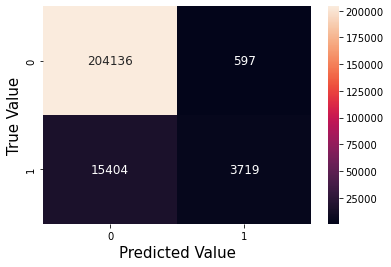

In [66]:
forest = RandomForestClassifier()
forest.fit(LS_train, HD1_train)
HD1_train_pred = forest.predict(LS_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", forest.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.9003950426833717


Text(33.0, 0.5, 'True Value')

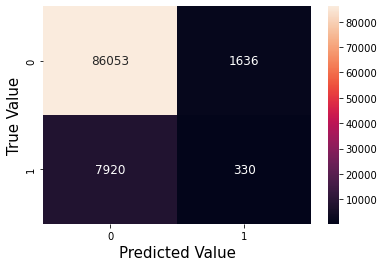

In [67]:
HD1_test_pred = forest.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", forest.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [68]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
RFLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
RFLS_Spec = TN / float(TN+FP)
#Precision
RFLS_Prec = TP/ float(TP+FP)
# Accuracy
RFLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
RFLS_f = 2*((RFLS_Sen*RFLS_Prec)/(RFLS_Prec+RFLS_Sen))
#False Positive Rate
RFLS_FPR = FP/ float(TN+FP)
#False Negative Rate
RFLS_FNR = FN/ float(TP+FN)

RFLS_result_un = [RFLS_Sen,RFLS_Spec,RFLS_Prec,RFLS_Acc,RFLS_f,RFLS_FPR,RFLS_FNR]

RF_Test_result_un = {'Algorithm ': ['Random Forest'],'Sensitivity ': [RFLS_Sen], 'Specificity': [RFLS_Spec],'Precision ': [RFLS_Prec],'Accuracy': [RFLS_Acc], 'F-score': [RFLS_f],'FPR ': [RFLS_FPR], 'FNR': [RFLS_FNR]}
RF_Test_un = pd.DataFrame(RF_Test_result_un)
RF_Test_un

Algorithm   Sensitivity   Specificity  Precision   Accuracy   F-score  \
0  Random Forest          0.04     0.981343    0.167854  0.900395  0.064605   

       FPR    FNR  
0  0.018657  0.96

Chaning depth significantly lower TP and FP

With Balanced data

In [69]:
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle_bal, y_res, train_size=0.7, test_size=0.3, random_state=100)

In [70]:
forest = RandomForestClassifier()
forest.fit(LS_train, HD1_train)

print("Accuracy on training set: {:.3f}".format(forest.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(LS_test, HD1_test)))

Accuracy on training set: 0.789
Accuracy on test set: 0.560


By default parameter, there is overfitting.

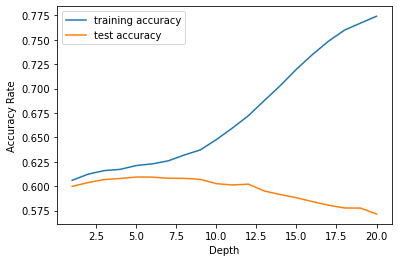

In [71]:
train_acc = [] 
test_acc = [] 
# try n_neighbors from 1 to 10 
x_range = range(1,21,1)
for var in x_range:
    gbrt = RandomForestClassifier(max_depth = var)
    gbrt.fit(LS_train, HD1_train)
    train_scr = gbrt.score(LS_train, HD1_train)
    test_scr = gbrt.score(LS_test, HD1_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)
    

plt.plot(x_range, train_acc, label="training accuracy") 
plt.plot(x_range, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Depth") 
plt.legend()

In [72]:
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline

In [73]:
pipe = Pipeline([("classifier", RandomForestClassifier())])

search_space = [{"classifier": [RandomForestClassifier()], "classifier__max_features": [1, 2, 3], "classifier__max_depth": [3, 5, 7]}]
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)
best_model = gridsearch.fit(LS_train, HD1_train)
best_model.best_estimator_.get_params()["classifier"]

RandomForestClassifier(max_depth=5, max_features=2)

To try to optimized the model, we plot out the change of accuracy with max_depth to determine a good depth without overfitting. From there we identify a few depth value which are good and use a pipeline to try out different parameter that would result in a optimal model.

In [74]:
forest = best_model.best_estimator_.get_params()["classifier"]
forest.fit(LS_train, HD1_train)

print("Accuracy on training set: {:.3f}".format(forest.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(LS_test, HD1_test)))

Accuracy on training set: 0.620
Accuracy on test set: 0.610


No much changes in Accuracy from the decision tree model as there are only 5 features, thus overfitting still result. 

A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results. This reduction in overfitting, while retaining the predictive power of the trees, can be shown using rigorous mathematics.

Introduction to Machine Learning with Python: A Guide for Data Scientists - (Page 83). 

Classification Accuracy 	: 0.6201398674390689


Text(33.0, 0.5, 'True Value')

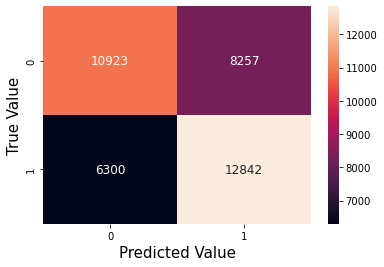

In [75]:
HD1_train_pred = forest.predict(LS_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", forest.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.6102654651729177


Text(33.0, 0.5, 'True Value')

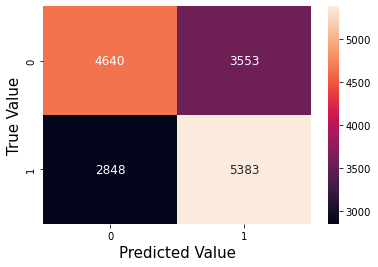

In [76]:
HD1_test_pred = forest.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", forest.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [77]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
RFLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
RFLS_Spec = TN / float(TN+FP)
#Precision
RFLS_Prec = TP/ float(TP+FP)
# Accuracy
RFLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
RFLS_f = 2*((RFLS_Sen*RFLS_Prec)/(RFLS_Prec+RFLS_Sen))
#False Positive Rate
RFLS_FPR = FP/ float(TN+FP)
#False Negative Rate
RFLS_FNR = FN/ float(TP+FN)

RFLS_result = [RFLS_Sen,RFLS_Spec,RFLS_Prec,RFLS_Acc,RFLS_f,RFLS_FPR,RFLS_FNR]

RF_Test_result = {'Algorithm ': ['Random Forest'],'Sensitivity ': [RFLS_Sen], 'Specificity': [RFLS_Spec],'Precision ': [RFLS_Prec],'Accuracy': [RFLS_Acc], 'F-score': [RFLS_f],'FPR ': [RFLS_FPR], 'FNR': [RFLS_FNR]}
RF_Test_bal = pd.DataFrame(RF_Test_result)
RF_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy   F-score  \
0  Random Forest      0.653991     0.566337    0.602395  0.610265  0.627133   

       FPR        FNR  
0  0.433663  0.346009

Still a relatively low accuracy

# Gradient boosted regression trees (gradient boosting machines)

In contrast to the random forest approach, gradient boosting works by building trees in a serial manner, 
where each tree tries to correct the mistakes of the previous one. By default, there is no randomization in gradient boosted 
regression trees; instead, strong pre-pruning is used. Gradient boosted trees often use very shallow trees, 
of depth one to five, which makes the model smaller in terms of memory and makes predictions faster.

Apart from the pre-pruning and the number of trees in the ensemble, another important parameter of gradient boosting is the 
learning_rate, which controls how strongly each tree tries to correct the mistakes of the previous trees. A higher learning 
rate means each tree can make stronger corrections, allowing for more complex mod‐ els. Adding more trees to the ensemble, 
which can be accomplished by increasing n_estimators, also increases the model complexity, as the model has more chances to 
correct mistakes on the training set.


Introduction to Machine Learning with Python: A Guide for Data Scientists - (Page 88) & (Page 89). . 

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

With Imbalanced data

In [79]:
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle, y, train_size=0.7, test_size=0.3, random_state=100)
gbrt = GradientBoostingClassifier(random_state=0) 
gbrt.fit(LS_train, HD1_train) 
print("Accuracy on training set: {:.3f}".format(gbrt.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(LS_test, HD1_test)))

Accuracy on training set: 0.915
Accuracy on test set: 0.914


Classification Accuracy 	: 0.9146013508684154


Text(33.0, 0.5, 'True Value')

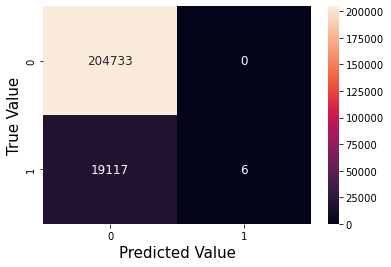

In [80]:
HD1_train_pred = gbrt.predict(LS_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.9139974358707095


Text(33.0, 0.5, 'True Value')

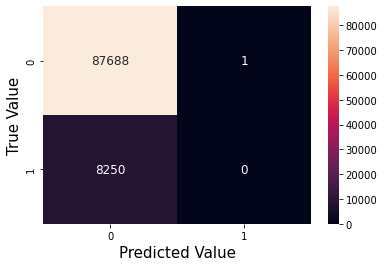

In [81]:
HD1_test_pred = gbrt.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [82]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
GBLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
GBLS_Spec = TN / float(TN+FP)
#Precision
GBLS_Prec = TP/ float(TP+FP)
# Accuracy
GBLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
GBLS_f = 2*((GBLS_Sen*GBLS_Prec)/(GBLS_Prec+GBLS_Sen))
#False Positive Rate
GBLS_FPR = FP/ float(TN+FP)
#False Negative Rate
GBLS_FNR = FN/ float(TP+FN)

GBLS_result_un = [GBLS_Sen,GBLS_Spec,GBLS_Prec,GBLS_Acc,GBLS_f,GBLS_FPR,GBLS_FNR]

GB_Test_result_un = {'Algorithm ': ['Gradient Boosted'],'Sensitivity ': [GBLS_Sen], 'Specificity': [GBLS_Spec],'Precision ': [GBLS_Prec],'Accuracy': [GBLS_Acc], 'F-score': [GBLS_f],'FPR ': [GBLS_FPR], 'FNR': [GBLS_FNR]}
GB_Test_bal_un = pd.DataFrame(GB_Test_result_un)
GB_Test_bal_un

Algorithm   Sensitivity   Specificity  Precision   Accuracy  F-score  \
0  Gradient Boosted           0.0     0.999989         0.0  0.913997      NaN   

       FPR   FNR  
0  0.000011  1.0

With Balanced data

In [83]:
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle_bal, y_res, train_size=0.7, test_size=0.3, random_state=100)
gbrt = GradientBoostingClassifier(random_state=0) 
gbrt.fit(LS_train, HD1_train) 
print("Accuracy on training set: {:.3f}".format(gbrt.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(LS_test, HD1_test)))

Accuracy on training set: 0.626
Accuracy on test set: 0.610


With default parameter, it already does not show overfitting. Let us see if there is other parameter which we can tune to increase its accuracy

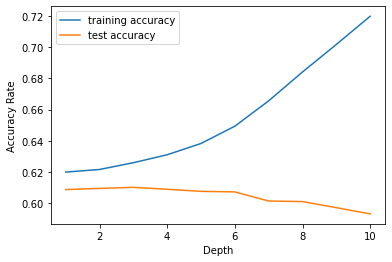

In [84]:
train_acc = [] 
test_acc = [] 
# try n_neighbors from 1 to 10 
x_range = range(1,11)
for var in x_range:
    gbrt = GradientBoostingClassifier(max_depth = var)
    gbrt.fit(LS_train, HD1_train)
    train_scr = gbrt.score(LS_train, HD1_train)
    test_scr = gbrt.score(LS_test, HD1_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)

plt.plot(x_range, train_acc, label="training accuracy") 
plt.plot(x_range, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Depth") 
plt.legend()

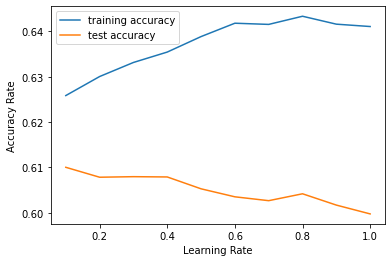

In [85]:
train_acc = [] 
test_acc = [] 
x_axis = []

# try n_neighbors from 1 to 10 
x_range = range(1,11,1)
for var in x_range:
    gbrt = GradientBoostingClassifier(learning_rate = var/10)
    gbrt.fit(LS_train, HD1_train)
    train_scr = gbrt.score(LS_train, HD1_train)
    test_scr = gbrt.score(LS_test, HD1_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)
    x_axis.append(var/10)

plt.plot(x_axis, train_acc, label="training accuracy") 
plt.plot(x_axis, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Learning Rate") 
plt.legend()

In [86]:
pipe = Pipeline([("classifier", GradientBoostingClassifier())])

search_space = [{"classifier": [GradientBoostingClassifier()], "classifier__learning_rate": [0.1, 0.2, 0.3], "classifier__max_depth": [2, 3, 4]}]
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)
best_model = gridsearch.fit(LS_train, HD1_train)
best_model.best_estimator_.get_params()["classifier"]

GradientBoostingClassifier(learning_rate=0.2)

In [87]:
gbrt = best_model.best_estimator_.get_params()["classifier"]
gbrt.fit(LS_train, HD1_train) 

GradientBoostingClassifier(learning_rate=0.2)

Classification Accuracy 	: 0.6300558425969417


Text(33.0, 0.5, 'True Value')

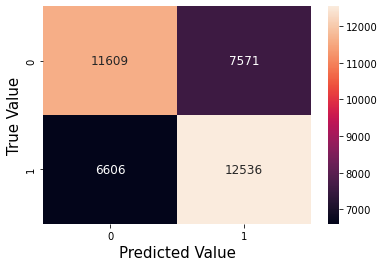

In [88]:
HD1_train_pred = gbrt.predict(LS_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.6078300048709206


Text(33.0, 0.5, 'True Value')

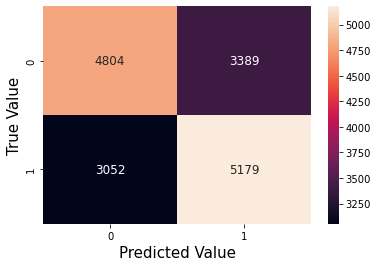

In [89]:
HD1_test_pred = gbrt.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [90]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
GBLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
GBLS_Spec = TN / float(TN+FP)
#Precision
GBLS_Prec = TP/ float(TP+FP)
# Accuracy
GBLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
GBLS_f = 2*((GBLS_Sen*GBLS_Prec)/(GBLS_Prec+GBLS_Sen))
#False Positive Rate
GBLS_FPR = FP/ float(TN+FP)
#False Negative Rate
GBLS_FNR = FN/ float(TP+FN)

GB_Test_result = {'Algorithm ': ['Gradient Boosted'],'Sensitivity ': [GBLS_Sen], 'Specificity': [GBLS_Spec],'Precision ': [GBLS_Prec],'Accuracy': [GBLS_Acc], 'F-score': [GBLS_f],'FPR ': [GBLS_FPR], 'FNR': [GBLS_FNR]}
GB_Test_bal = pd.DataFrame(GB_Test_result)
GB_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  Gradient Boosted      0.629207     0.586354    0.604458   0.60783   

    F-score      FPR        FNR  
0  0.616584  0.413646  0.370793

Overfitting is not observed 

# k-Nearest Neighbors

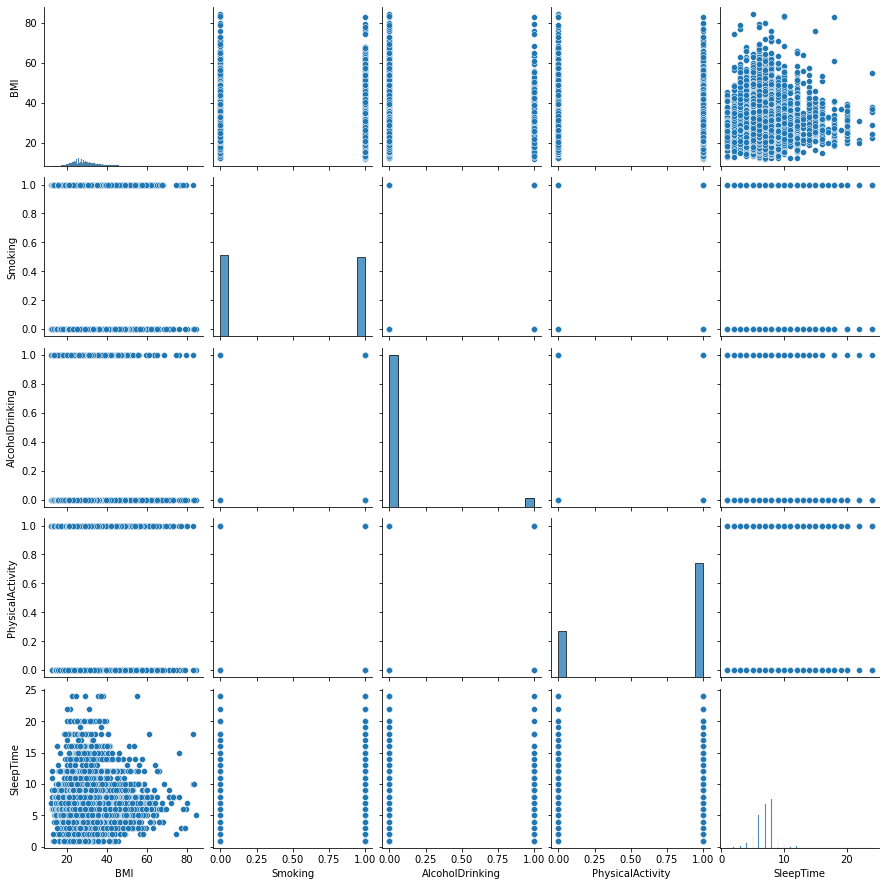

In [91]:
sb.pairplot(Lifestyle_bal)

With Imbalance data

In [92]:
from sklearn.neighbors import KNeighborsClassifier 
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle, y, train_size=0.7, test_size=0.3, random_state=100)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaler.fit(LS_train)

cols = LS_train.columns
LS_train = pd.DataFrame(scaler.transform(LS_train))
LS_train.columns = cols

cols = LS_test.columns
LS_test = pd.DataFrame(scaler.transform(LS_test))
LS_test.columns = cols

clf = KNeighborsClassifier() 
clf.fit(LS_train, HD1_train) 
print("Accuracy on training set: {:.3f}".format(clf.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(clf.score(LS_test, HD1_test)))

Accuracy on training set: 0.914
Accuracy on test set: 0.907


Classification Accuracy 	: 0.9135515688656993


Text(33.0, 0.5, 'True Value')

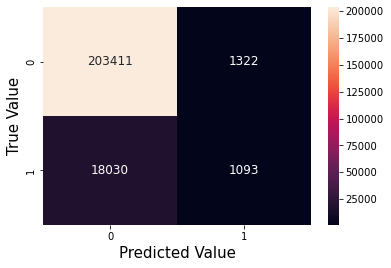

In [93]:
HD1_train_pred = clf.predict(LS_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", clf.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.9069512919667706


Text(33.0, 0.5, 'True Value')

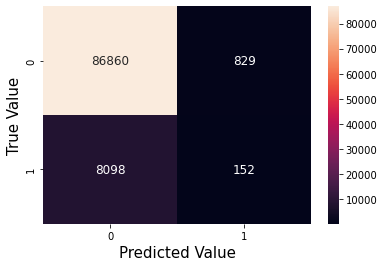

In [94]:
HD1_test_pred = clf.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", clf.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [95]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
kkLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
kkLS_Spec = TN / float(TN+FP)
#Precision
kkLS_Prec = TP/ float(TP+FP)
# Accuracy
kkLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
kkLS_f = 2*((kkLS_Sen*kkLS_Prec)/(kkLS_Prec+kkLS_Sen))
#False Positive Rate
kkLS_FPR = FP/ float(TN+FP)
#False Negative Rate
kkLS_FNR = FN/ float(TP+FN)

kkLS_result_un = [kkLS_Sen,kkLS_Spec,kkLS_Prec,kkLS_Acc,kkLS_f,kkLS_FPR,kkLS_FNR]

kk_Test_result_un = {'Algorithm ': ['K-Nearest Neighbour'],'Sensitivity ': [kkLS_Sen], 'Specificity': [kkLS_Spec],'Precision ': [kkLS_Prec],'Accuracy': [kkLS_Acc], 'F-score': [kkLS_f],'FPR ': [kkLS_FPR], 'FNR': [kkLS_FNR]}
kk_Test_bal_un = pd.DataFrame(kk_Test_result_un)
kk_Test_bal_un

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  K-Nearest Neighbour      0.018424     0.990546    0.154944  0.906951   

    F-score      FPR        FNR  
0  0.032933  0.009454  0.981576

As seen from the plot, the scale use for different variable are different. SleepTime and BMI has very high values but Smoking, AlcoholDrinking and PhysicalActivity are only 0 and 1. To resolve this, we scale the variable to ensure that they are between 0 and 1.

Balanced Data

In [96]:
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle_bal, y_res, train_size=0.7, test_size=0.3, random_state=100)

In [97]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaler.fit(LS_train)

cols = LS_train.columns
LS_train = pd.DataFrame(scaler.transform(LS_train))
LS_train.columns = cols

cols = LS_test.columns
LS_test = pd.DataFrame(scaler.transform(LS_test))
LS_test.columns = cols

In [98]:
LS_train

BMI  Smoking  AlcoholDrinking  PhysicalActivity  SleepTime
0      0.137597      0.0              0.0               1.0   0.304348
1      0.221346      1.0              0.0               1.0   0.260870
2      0.205703      0.0              0.0               0.0   0.391304
3      0.226883      1.0              0.0               1.0   0.304348
4      0.293051      0.0              0.0               1.0   0.304348
...         ...      ...              ...               ...        ...
38317  0.088594      1.0              0.0               1.0   0.304348
38318  0.206534      1.0              0.0               1.0   0.304348
38319  0.261489      1.0              0.0               1.0   0.260870
38320  0.293189      0.0              0.0               1.0   0.347826
38321  0.188538      0.0              0.0               1.0   0.173913

[38322 rows x 5 columns]

In [99]:
LS_test

BMI  Smoking  AlcoholDrinking  PhysicalActivity  SleepTime
0      0.525748      0.0              0.0               1.0   0.217391
1      0.236573      1.0              0.0               0.0   0.217391
2      0.107143      1.0              0.0               1.0   0.304348
3      0.142027      0.0              0.0               1.0   0.304348
4      0.158223      1.0              0.0               0.0   0.304348
...         ...      ...              ...               ...        ...
16419  0.243079      0.0              0.0               1.0   0.304348
16420  0.427326      1.0              0.0               0.0   0.086957
16421  0.138981      0.0              0.0               1.0   0.260870
16422  0.187846      1.0              0.0               1.0   0.304348
16423  0.325720      1.0              0.0               1.0   0.304348

[16424 rows x 5 columns]

In [100]:
clf = KNeighborsClassifier()
clf.fit(LS_train, HD1_train) 
print("Accuracy on training set: {:.3f}".format(clf.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(clf.score(LS_test, HD1_test)))

Accuracy on training set: 0.687
Accuracy on test set: 0.556


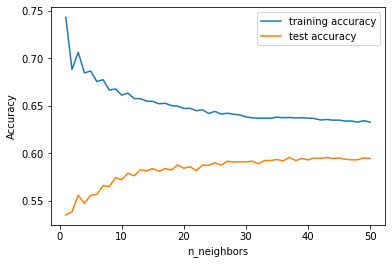

In [101]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 51) 
for n_neighbors in neighbors_settings: # build the model 
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(LS_train, HD1_train) # record training set accuracy 
    training_accuracy.append(clf.score(LS_train, HD1_train)) # record generalization accuracy 
    test_accuracy.append(clf.score(LS_test, HD1_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("n_neighbors") 
plt.legend()

In [102]:
clf = KNeighborsClassifier(n_neighbors=49)
clf.fit(LS_train, HD1_train)

KNeighborsClassifier(n_neighbors=49)

Classification Accuracy 	: 0.6343353687177078


Text(33.0, 0.5, 'True Value')

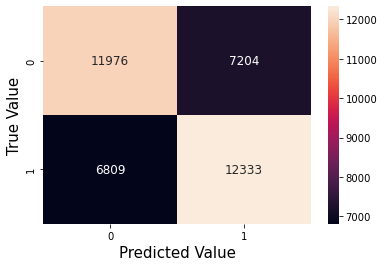

In [103]:
HD1_train_pred = clf.predict(LS_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", clf.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

<AxesSubplot:xlabel='Cluster', ylabel='count'>

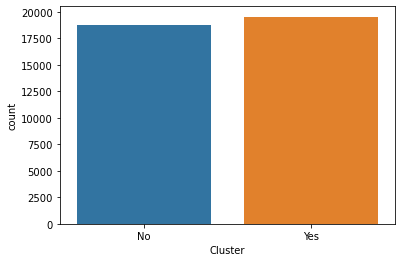

In [104]:
# Predict the Cluster Labels
HD1_train_pred = clf.predict(LS_train)

# Append Labels to the Data
LS_train_labeled = LS_train.copy()
LS_train_labeled["Cluster"] = pd.Categorical(HD1_train_pred)

# Summary of the Cluster Labels
sb.countplot(x=LS_train_labeled["Cluster"])

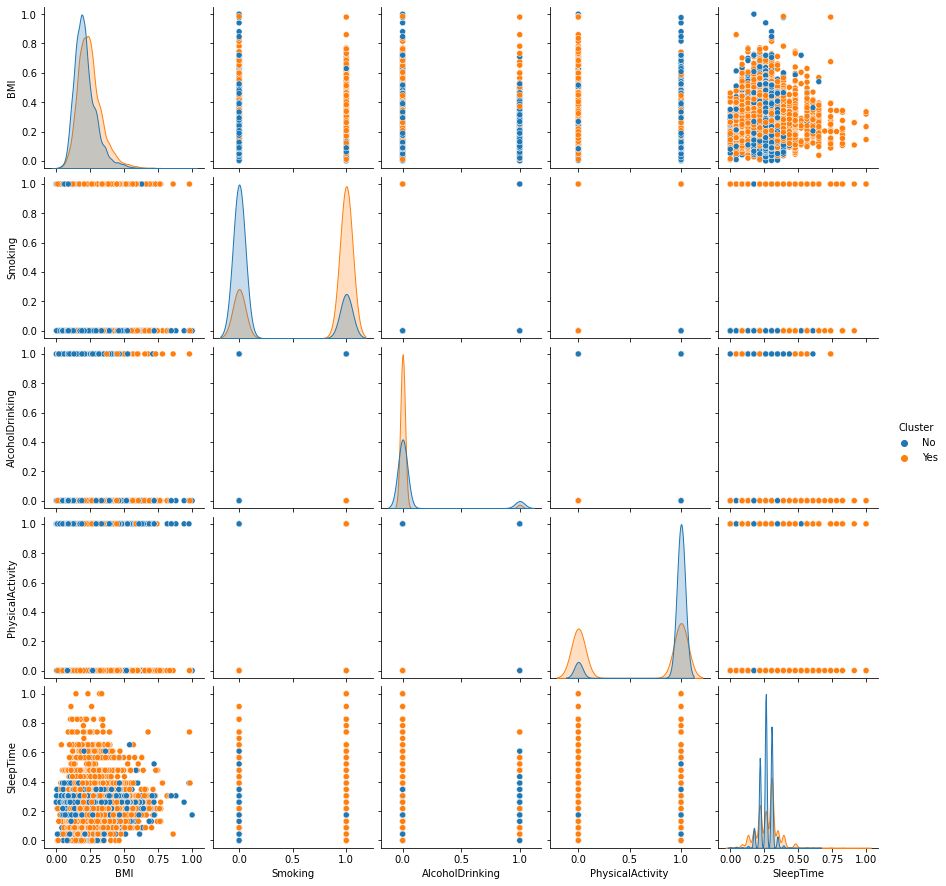

In [105]:
# Plot the Clusters on 2D grids
sb.pairplot(LS_train_labeled, vars = LS_train.columns.values, hue = "Cluster")

Classification Accuracy 	: 0.5952264978080857


Text(33.0, 0.5, 'True Value')

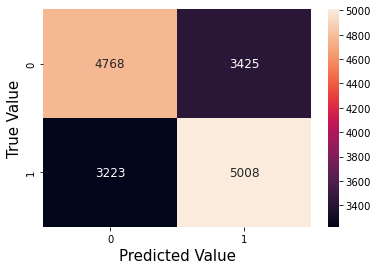

In [106]:
HD1_test_pred = clf.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", clf.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [107]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
kkLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
kkLS_Spec = TN / float(TN+FP)
#Precision
kkLS_Prec = TP/ float(TP+FP)
# Accuracy
kkLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
kkLS_f = 2*((kkLS_Sen*kkLS_Prec)/(kkLS_Prec+kkLS_Sen))
#False Positive Rate
kkLS_FPR = FP/ float(TN+FP)
#False Negative Rate
kkLS_FNR = FN/ float(TP+FN)

kkLS_result = [kkLS_Sen,kkLS_Spec,kkLS_Prec,kkLS_Acc,kkLS_f,kkLS_FPR,kkLS_FNR]

kk_Test_result = {'Algorithm ': ['K-Nearest Neighbour'],'Sensitivity ': [kkLS_Sen], 'Specificity': [kkLS_Spec],'Precision ': [kkLS_Prec],'Accuracy': [kkLS_Acc], 'F-score': [kkLS_f],'FPR ': [kkLS_FPR], 'FNR': [kkLS_FNR]}
kk_Test_bal = pd.DataFrame(kk_Test_result)
kk_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  K-Nearest Neighbour      0.608432      0.58196    0.593857  0.595226   

    F-score     FPR        FNR  
0  0.601056  0.41804  0.391568

# Logistic Regression

Imbalanced data

In [108]:
from sklearn.linear_model import LogisticRegression

In [109]:
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle, y, train_size=0.7, test_size=0.3, random_state=100)
reg = LogisticRegression()
reg.fit(LS_train, HD1_train)
HD1_train_pred = reg.predict(LS_train)
print("Accuracy on training set: {:.3f}".format(reg.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(reg.score(LS_test, HD1_test)))

Accuracy on training set: 0.915
Accuracy on test set: 0.914


Classification Accuracy 	: 0.9145745479236652


Text(33.0, 0.5, 'True Value')

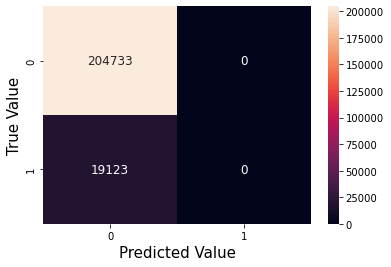

In [110]:
# Print the Classification Accuracy
print("Classification Accuracy \t:", reg.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.9140078591605082


Text(33.0, 0.5, 'True Value')

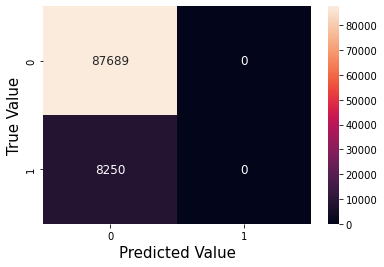

In [111]:
HD1_test_pred = reg.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", reg.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [112]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
lgLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
lgLS_Spec = TN / float(TN+FP)
#Precision
lgLS_Prec = TP/ float(TP+FP)
# Accuracy
lgLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
lgLS_f = 2*((lgLS_Sen*lgLS_Prec)/(lgLS_Prec+lgLS_Sen))
#False Positive Rate
lgLS_FPR = FP/ float(TN+FP)
#False Negative Rate
lgLS_FNR = FN/ float(TP+FN)

lgLS_result_un = [lgLS_Sen,lgLS_Spec,lgLS_Prec,lgLS_Acc,lgLS_f,lgLS_FPR,lgLS_FNR]

lg_Test_result_un = {'Algorithm ': ['Logistic Regression'],'Sensitivity ': [lgLS_Sen], 'Specificity': [lgLS_Spec],'Precision ': [lgLS_Prec],'Accuracy': [lgLS_Acc], 'F-score': [lgLS_f],'FPR ': [lgLS_FPR], 'FNR': [lgLS_FNR]}
lg_Test_bal_un = pd.DataFrame(lg_Test_result_un)
lg_Test_bal_un

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  Logistic Regression           0.0          1.0         NaN  0.914008   

   F-score  FPR   FNR  
0      NaN   0.0  1.0

With Balanced data

In [113]:
LS_train, LS_test, HD1_train, HD1_test = train_test_split(Lifestyle_bal, y_res, train_size=0.7, test_size=0.3, random_state=100)
reg = LogisticRegression()
reg.fit(LS_train, HD1_train)
HD1_train_pred = reg.predict(LS_train)
print("Accuracy on training set: {:.3f}".format(reg.score(LS_train, HD1_train))) 
print("Accuracy on test set: {:.3f}".format(reg.score(LS_test, HD1_test)))

Accuracy on training set: 0.612
Accuracy on test set: 0.603


For LogisticRegression and LinearSVC the trade-off parameter that determines the strength of the regularization is called C, and higher values of C correspond to less regularization. In other words, when you use a high value for the parameter C, Logis ticRegression and LinearSVC try to fit the training set as best as possible, while with low values of the parameter C, the models put more emphasis on finding a coefficient vector (w) that is close to zero.

Introduction to Machine Learning with Python: A Guide for Data Scientists - (Page 57) & (Page 58). 

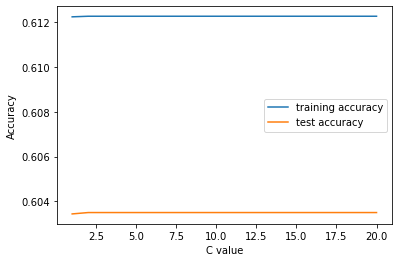

In [114]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 21) 
for var in neighbors_settings: # build the model 
    reg = LogisticRegression(C = var) 
    reg.fit(LS_train, HD1_train) # record training set accuracy 
    training_accuracy.append(reg.score(LS_train, HD1_train)) # record generalization accuracy 
    test_accuracy.append(reg.score(LS_test, HD1_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("C value") 
plt.legend()

In [115]:
reg = LogisticRegression(C = 2)
reg.fit(LS_train, HD1_train)
HD1_train_pred = reg.predict(LS_train)

Classification Accuracy 	: 0.6122592766557069


Text(33.0, 0.5, 'True Value')

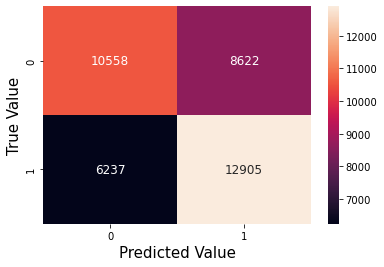

In [116]:
# Print the Classification Accuracy
print("Classification Accuracy \t:", reg.score(LS_train, HD1_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_train, HD1_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.6035070628348758


Text(33.0, 0.5, 'True Value')

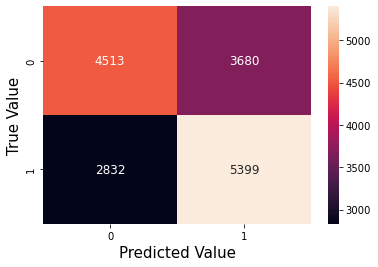

In [117]:
HD1_test_pred = reg.predict(LS_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", reg.score(LS_test, HD1_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD1_test, HD1_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [118]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
lgLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
lgLS_Spec = TN / float(TN+FP)
#Precision
lgLS_Prec = TP/ float(TP+FP)
# Accuracy
lgLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
lgLS_f = 2*((lgLS_Sen*lgLS_Prec)/(lgLS_Prec+lgLS_Sen))
#False Positive Rate
lgLS_FPR = FP/ float(TN+FP)
#False Negative Rate
lgLS_FNR = FN/ float(TP+FN)

lgLS_result = [lgLS_Sen,lgLS_Spec,lgLS_Prec,lgLS_Acc,lgLS_f,lgLS_FPR,lgLS_FNR]

lg_Test_result = {'Algorithm ': ['Logistic Regression'],'Sensitivity ': [lgLS_Sen], 'Specificity': [lgLS_Spec],'Precision ': [lgLS_Prec],'Accuracy': [lgLS_Acc], 'F-score': [lgLS_f],'FPR ': [lgLS_FPR], 'FNR': [lgLS_FNR]}
lg_Test_bal = pd.DataFrame(lg_Test_result)
lg_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  Logistic Regression      0.655935     0.550836    0.594669  0.603507   

    F-score      FPR        FNR  
0  0.623801  0.449164  0.344065

# Algorithm performance

In [119]:
Imbalance_result = pd.concat([DT_Test_un,RF_Test_un,GB_Test_bal_un,kk_Test_bal_un, lg_Test_bal_un], axis = 0)
Imbalance_result

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0        Decision Tree      0.000000     1.000000         NaN  0.914008   
0        Random Forest      0.040000     0.981343    0.167854  0.900395   
0     Gradient Boosted      0.000000     0.999989    0.000000  0.913997   
0  K-Nearest Neighbour      0.018424     0.990546    0.154944  0.906951   
0  Logistic Regression      0.000000     1.000000         NaN  0.914008   

    F-score      FPR        FNR  
0       NaN  0.000000  1.000000  
0  0.064605  0.018657  0.960000  
0       NaN  0.000011  1.000000  
0  0.032933  0.009454  0.981576  
0       NaN  0.000000  1.000000

In [120]:
Balance_result = pd.concat([DT_Test_bal,RF_Test_bal,GB_Test_bal,kk_Test_bal, lg_Test_bal], axis = 0)
Balance_result

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0        Decision Tree      0.667355     0.538753    0.592429  0.603203   
0        Random Forest      0.653991     0.566337    0.602395  0.610265   
0     Gradient Boosted      0.629207     0.586354    0.604458  0.607830   
0  K-Nearest Neighbour      0.608432     0.581960    0.593857  0.595226   
0  Logistic Regression      0.655935     0.550836    0.594669  0.603507   

    F-score      FPR        FNR  
0  0.627664  0.461247  0.332645  
0  0.627133  0.433663  0.346009  
0  0.616584  0.413646  0.370793  
0  0.601056  0.418040  0.391568  
0  0.623801  0.449164  0.344065

In general, the unbiased data allowed for a better FNR than the bias data. This is extremely important as patient with disease but not detected by the algorithm could proof severe to their survival.
Of the five algorithm, Random Forest and Logistic Regression gave the best model for the Lifestyle variable by comparing their FNR.

Moving on, we wish to use Decision Tree, Random Forest, Gradient boosted Reg, K-nearest Neighbour and Logistic Regression on general health data

# General Health with non biased data

In [121]:
GeneralHealth = X_res[['Stroke','Diabetic','Asthma','KidneyDisease','SkinCancer']]
GeneralHealth.head()

Stroke  Diabetic  Asthma  KidneyDisease  SkinCancer
0       0         0       0              0           0
1       0         0       0              0           0
2       0         0       0              0           0
3       0         0       0              0           0
4       0         0       0              0           0

In [122]:
GeneralHealth_table = pd.concat([y_res2,GeneralHealth],axis=1)
GeneralHealth_table

HeartDisease  Stroke  Diabetic  Asthma  KidneyDisease  SkinCancer
0                 0       0         0       0              0           0
1                 0       0         0       0              0           0
2                 0       0         0       0              0           0
3                 0       0         0       0              0           0
4                 0       0         0       0              0           0
...             ...     ...       ...     ...            ...         ...
54741             1       0         1       0              1           0
54742             1       0         1       0              1           0
54743             1       0         0       0              0           0
54744             1       0         0       0              0           0
54745             1       0         0       0              0           0

[54746 rows x 6 columns]

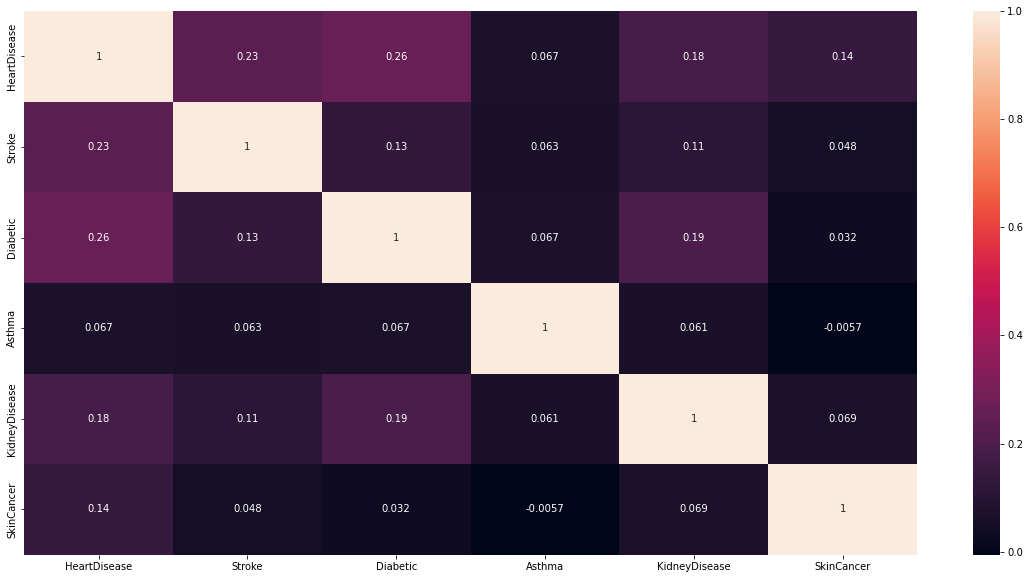

In [123]:
plt.figure(figsize = (20,10))
sb.heatmap(GeneralHealth_table.corr(),annot = True)
plt.show()

In [124]:
GeneralHealth.shape

(54746, 5)

In [125]:
from sklearn.model_selection import train_test_split
GH_train, GH_test, HD_train, HD_test = train_test_split(GeneralHealth, y_res, train_size=0.7, test_size=0.3, random_state=100)
print("Train Set :", HD_train.shape, GH_train.shape)
print("Test Set  :", HD_test.shape, GH_test.shape)

Train Set : (38322, 1) (38322, 5)
Test Set  : (16424, 1) (16424, 5)


# Decision Tree

In [126]:
dectree = DecisionTreeClassifier()
dectree.fit(GH_train, HD_train)

print("Accuracy on training set: {:.3f}".format(dectree.score(GH_train, HD_train))) 
print("Accuracy on test set: {:.3f}".format(dectree.score(GH_test, HD_test)))

Accuracy on training set: 0.674
Accuracy on test set: 0.673


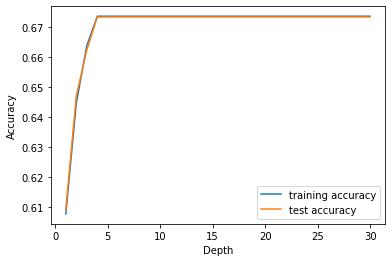

In [127]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 31) 
for var in neighbors_settings: # build the model 
    dectree = DecisionTreeClassifier(max_depth = var) 
    dectree.fit(GH_train, HD_train) # record training set accuracy 
    training_accuracy.append(dectree.score(GH_train, HD_train)) # record generalization accuracy 
    test_accuracy.append(dectree.score(GH_test, HD_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("Depth") 
plt.legend()

[Text(0.5, 0.875, 'Diabetic <= 0.5\ngini = 0.5\nsamples = 38322\nvalue = [19180, 19142]\nclass = No'),
 Text(0.25, 0.625, 'Stroke <= 0.5\ngini = 0.49\nsamples = 29951\nvalue = [17049, 12902]\nclass = No'),
 Text(0.125, 0.375, 'SkinCancer <= 0.5\ngini = 0.48\nsamples = 27753\nvalue = [16658, 11095]\nclass = No'),
 Text(0.0625, 0.125, 'gini = 0.467\nsamples = 24332\nvalue = [15315, 9017]\nclass = No'),
 Text(0.1875, 0.125, 'gini = 0.477\nsamples = 3421\nvalue = [1343, 2078]\nclass = Yes'),
 Text(0.375, 0.375, 'KidneyDisease <= 0.5\ngini = 0.292\nsamples = 2198\nvalue = [391, 1807]\nclass = Yes'),
 Text(0.3125, 0.125, 'gini = 0.307\nsamples = 1910\nvalue = [362, 1548]\nclass = Yes'),
 Text(0.4375, 0.125, 'gini = 0.181\nsamples = 288\nvalue = [29, 259]\nclass = Yes'),
 Text(0.75, 0.625, 'Stroke <= 0.5\ngini = 0.38\nsamples = 8371\nvalue = [2131, 6240]\nclass = Yes'),
 Text(0.625, 0.375, 'KidneyDisease <= 0.5\ngini = 0.408\nsamples = 7009\nvalue = [2003, 5006]\nclass = Yes'),
 Text(0.5625, 

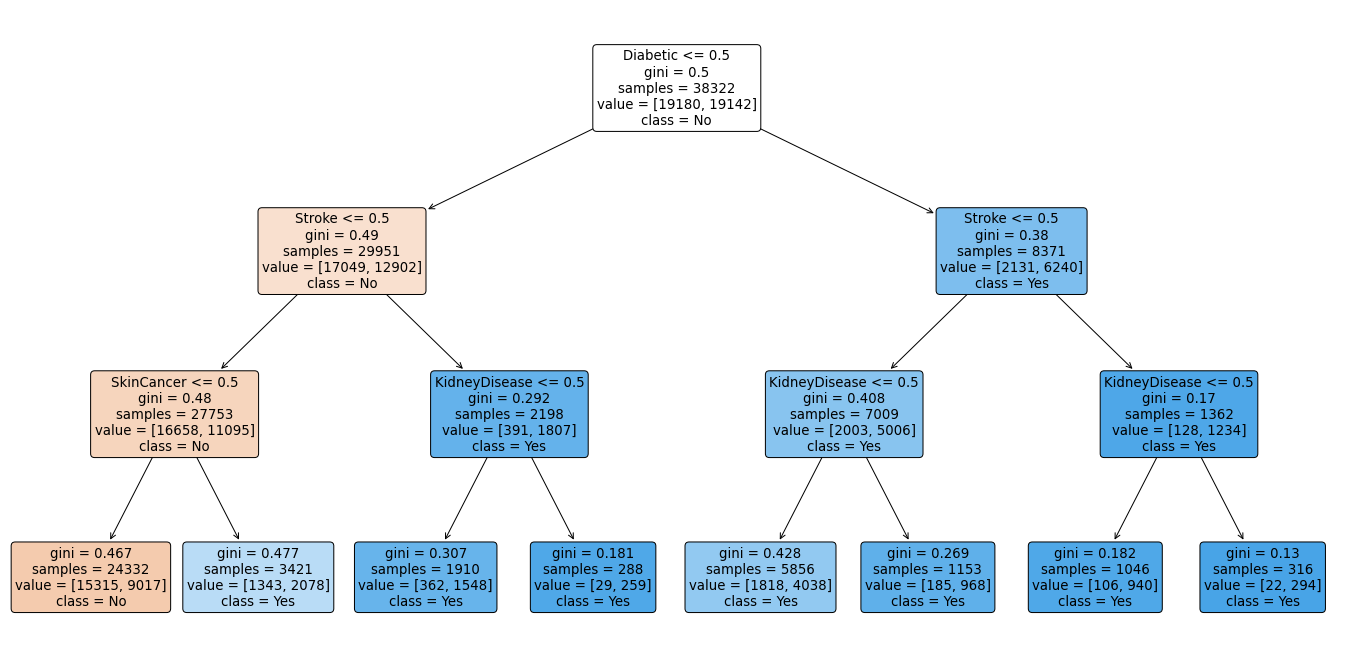

In [128]:
# Train the Decision Tree Classifier model
dectree = DecisionTreeClassifier(max_depth = 3)
dectree.fit(GH_train, HD_train)

# Plot the trained Decision Tree
#from sklearn.tree import plot_tree
f = plt.figure(figsize=(24,12))
plot_tree(dectree, filled=True, rounded=True, feature_names=['Stroke','Diabetic','Asthma','KidneyDisease','SkinCancer'], class_names=["No","Yes"])

Classification Accuracy 	: 0.6638484421481133


Text(33.0, 0.5, 'True Value')

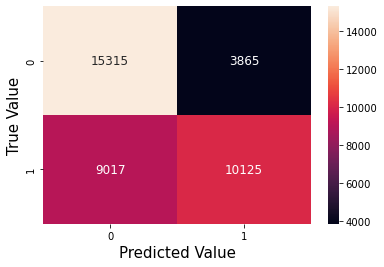

In [129]:
HD_train_pred = dectree.predict(GH_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(GH_train, HD_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_train, HD_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.662445202143205


Text(33.0, 0.5, 'True Value')

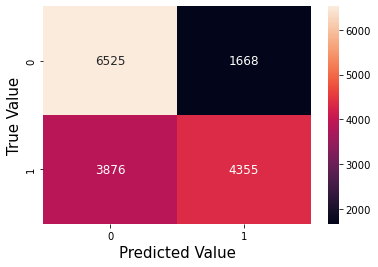

In [130]:
HD_test_pred = dectree.predict(GH_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", dectree.score(GH_test, HD_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_test, HD_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [131]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
DTLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
DTLS_Spec = TN / float(TN+FP)
#Precision
DTLS_Prec = TP/ float(TP+FP)
# Accuracy
DTLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
DTLS_f = 2*((DTLS_Sen*DTLS_Prec)/(DTLS_Prec+DTLS_Sen))
#False Positive Rate
DTLS_FPR = FP/ float(TN+FP)
#False Negative Rate
DTLS_FNR = FN/ float(TP+FN)

DTLS2_result = [DTLS_Sen,DTLS_Spec,DTLS_Prec,DTLS_Acc,DTLS_f,DTLS_FPR,DTLS_FNR]

DT2_Test_result = {'Algorithm ': ['Decision Tree'],'Sensitivity ': [DTLS_Sen], 'Specificity': [DTLS_Spec],'Precision ': [DTLS_Prec],'Accuracy': [DTLS_Acc], 'F-score': [DTLS_f],'FPR ': [DTLS_FPR], 'FNR': [DTLS_FNR]}
DT2_Test_bal = pd.DataFrame(DT2_Test_result)
DT2_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy   F-score  \
0  Decision Tree      0.529097     0.796412    0.723062  0.662445  0.611057   

       FPR        FNR  
0  0.203588  0.470903

# Random Forest

In [132]:
forest = RandomForestClassifier()
forest.fit(GH_train, HD_train)

print("Accuracy on training set: {:.3f}".format(forest.score(GH_train, HD_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(GH_test, HD_test)))

Accuracy on training set: 0.674
Accuracy on test set: 0.673


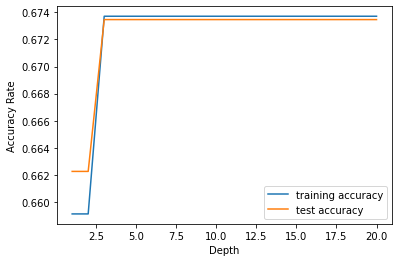

In [133]:
train_acc = [] 
test_acc = [] 
# try n_neighbors from 1 to 10 
x_range = range(1,21,1)
for var in x_range:
    forest = RandomForestClassifier(max_depth = var)
    forest.fit(GH_train, HD_train)
    train_scr = forest.score(GH_train, HD_train)
    test_scr = forest.score(GH_test, HD_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)
    

plt.plot(x_range, train_acc, label="training accuracy") 
plt.plot(x_range, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Depth") 
plt.legend()

In [134]:
pipe = Pipeline([("classifier", RandomForestClassifier())])

search_space = [{"classifier": [RandomForestClassifier()], "classifier__max_features": [1, 2, 3], "classifier__max_depth": [1, 2, 3, 4]}]
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)
best_model = gridsearch.fit(GH_train, HD_train)
best_model.best_estimator_.get_params()["classifier"]

RandomForestClassifier(max_depth=2, max_features=1)

In [135]:
forest = best_model.best_estimator_.get_params()["classifier"]
forest.fit(GH_train, HD_train)

print("Accuracy on training set: {:.3f}".format(forest.score(GH_train, HD_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(GH_test, HD_test)))

Accuracy on training set: 0.674
Accuracy on test set: 0.673


Classification Accuracy 	: 0.67371222796305


Text(33.0, 0.5, 'True Value')

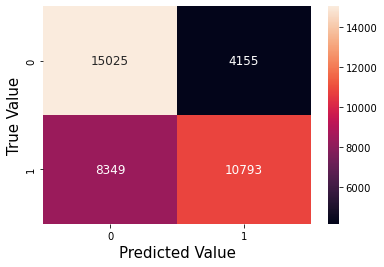

In [136]:
HD_train_pred = forest.predict(GH_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", forest.score(GH_train, HD_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_train, HD_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.6734656600097418


Text(33.0, 0.5, 'True Value')

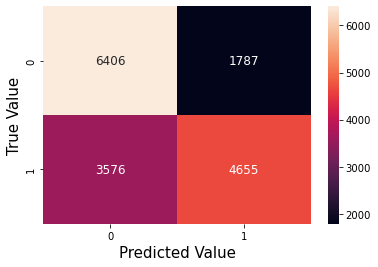

In [137]:
HD_test_pred = forest.predict(GH_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", forest.score(GH_test, HD_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_test, HD_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [138]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
RFLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
RFLS_Spec = TN / float(TN+FP)
#Precision
RFLS_Prec = TP/ float(TP+FP)
# Accuracy
RFLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
RFLS_f = 2*((RFLS_Sen*RFLS_Prec)/(RFLS_Prec+RFLS_Sen))
#False Positive Rate
RFLS_FPR = FP/ float(TN+FP)
#False Negative Rate
RFLS_FNR = FN/ float(TP+FN)

RFLS2_result = [RFLS_Sen,RFLS_Spec,RFLS_Prec,RFLS_Acc,RFLS_f,RFLS_FPR,RFLS_FNR]

RF2_Test_result = {'Algorithm ': ['Random Forest'],'Sensitivity ': [RFLS_Sen], 'Specificity': [RFLS_Spec],'Precision ': [RFLS_Prec],'Accuracy': [RFLS_Acc], 'F-score': [RFLS_f],'FPR ': [RFLS_FPR], 'FNR': [RFLS_FNR]}
RF2_Test_bal = pd.DataFrame(RF2_Test_result)
RF2_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy   F-score  \
0  Random Forest      0.565545     0.781887    0.722602  0.673466  0.634499   

       FPR        FNR  
0  0.218113  0.434455

# Gradient Boosted Regression

In [139]:
gbrt = GradientBoostingClassifier(random_state=0) 
gbrt.fit(GH_train, HD_train) 
print("Accuracy on training set: {:.3f}".format(gbrt.score(GH_train, HD_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(GH_test, HD_test)))

Accuracy on training set: 0.674
Accuracy on test set: 0.673


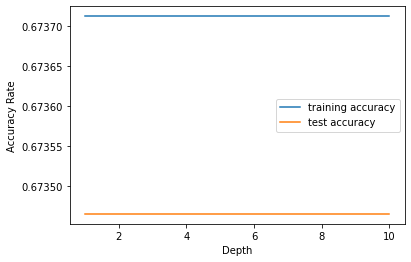

In [140]:
train_acc = [] 
test_acc = [] 
# try n_neighbors from 1 to 10 
x_range = range(1,11)
for var in x_range:
    gbrt = GradientBoostingClassifier(max_depth = var)
    gbrt.fit(GH_train, HD_train)
    train_scr = gbrt.score(GH_train, HD_train)
    test_scr = gbrt.score(GH_test, HD_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)

plt.plot(x_range, train_acc, label="training accuracy") 
plt.plot(x_range, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Depth") 
plt.legend()

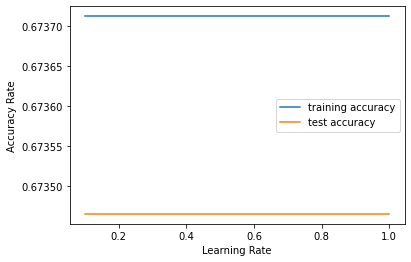

In [141]:
train_acc = [] 
test_acc = [] 
x_axis = []
# try n_neighbors from 1 to 10 
x_range = range(1,11,1)
for var in x_range:
    gbrt = GradientBoostingClassifier(learning_rate = var/10)
    gbrt.fit(GH_train, HD_train)
    train_scr = gbrt.score(GH_train, HD_train)
    test_scr = gbrt.score(GH_test, HD_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)
    x_axis.append(var/10)

plt.plot(x_axis, train_acc, label="training accuracy") 
plt.plot(x_axis, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Learning Rate") 
plt.legend()

Classification Accuracy 	: 0.67371222796305


Text(33.0, 0.5, 'True Value')

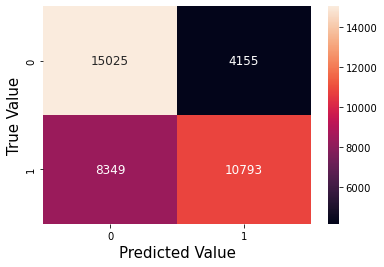

In [142]:
gbrt = GradientBoostingClassifier(random_state=0) 
gbrt.fit(GH_train, HD_train)
HD_train_pred = gbrt.predict(GH_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(GH_train, HD_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_train, HD_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.6734656600097418


Text(33.0, 0.5, 'True Value')

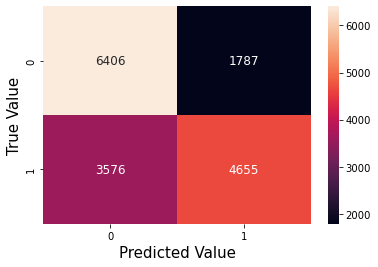

In [143]:
HD_test_pred = gbrt.predict(GH_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(GH_test, HD_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_test, HD_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [144]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
GBLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
GBLS_Spec = TN / float(TN+FP)
#Precision
GBLS_Prec = TP/ float(TP+FP)
# Accuracy
GBLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
GBLS_f = 2*((GBLS_Sen*GBLS_Prec)/(GBLS_Prec+GBLS_Sen))
#False Positive Rate
GBLS_FPR = FP/ float(TN+FP)
#False Negative Rate
GBLS_FNR = FN/ float(TP+FN)

GB2_Test_result = {'Algorithm ': ['Gradient Boosted'],'Sensitivity ': [GBLS_Sen], 'Specificity': [GBLS_Spec],'Precision ': [GBLS_Prec],'Accuracy': [GBLS_Acc], 'F-score': [GBLS_f],'FPR ': [GBLS_FPR], 'FNR': [GBLS_FNR]}
GB2_Test_bal = pd.DataFrame(GB2_Test_result)
GB2_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  Gradient Boosted      0.565545     0.781887    0.722602  0.673466   

    F-score      FPR        FNR  
0  0.634499  0.218113  0.434455

# k-Nearest Neighbors

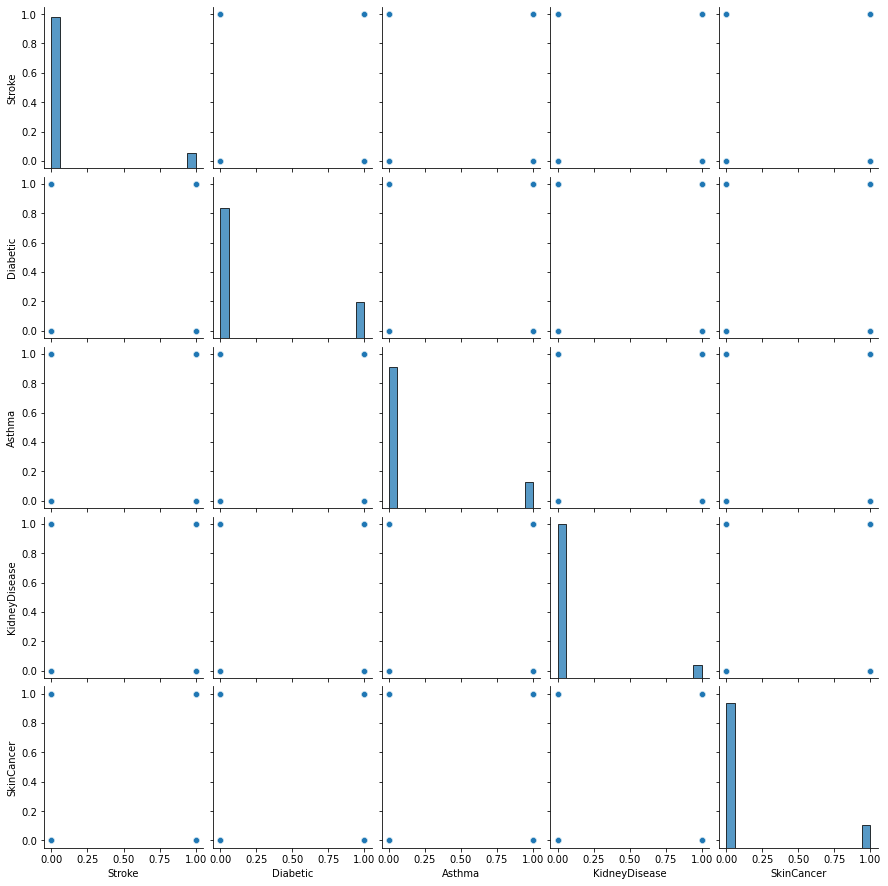

In [145]:
sb.pairplot(GeneralHealth)

Since the selected features are already of the same axis range, no scaling is necessary in this case

In [146]:
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaler.fit(GH_train)

cols = GH_train.columns
GH_train = pd.DataFrame(scaler.transform(GH_train))
GH_train.columns = cols

cols = GH_test.columns
GH_test = pd.DataFrame(scaler.transform(GH_test))
GH_test.columns = cols

clf = KNeighborsClassifier() 
clf.fit(GH_train, HD_train) 
print("Accuracy on training set: {:.3f}".format(clf.score(GH_train, HD_train))) 
print("Accuracy on test set: {:.3f}".format(clf.score(GH_test, HD_test)))

Accuracy on training set: 0.652
Accuracy on test set: 0.650


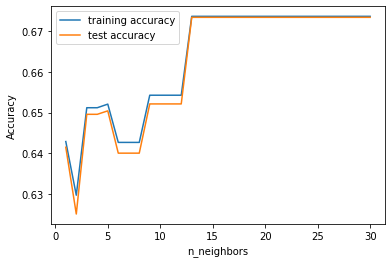

In [147]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 31) 
for n_neighbors in neighbors_settings: # build the model 
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(GH_train, HD_train) # record training set accuracy 
    training_accuracy.append(clf.score(GH_train, HD_train)) # record generalization accuracy 
    test_accuracy.append(clf.score(GH_test, HD_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("n_neighbors") 
plt.legend()

In [148]:
clf = KNeighborsClassifier(n_neighbors=29)
clf.fit(GH_train, HD_train)

KNeighborsClassifier(n_neighbors=29)

Classification Accuracy 	: 0.67371222796305


Text(33.0, 0.5, 'True Value')

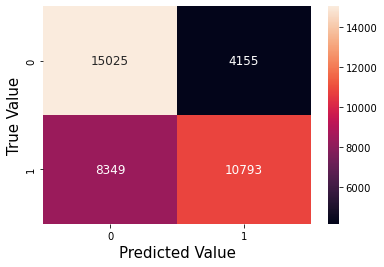

In [149]:
HD_train_pred = clf.predict(GH_train)

# Print the Classification Accuracy
print("Classification Accuracy \t:", clf.score(GH_train, HD_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_train, HD_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

<AxesSubplot:xlabel='Cluster', ylabel='count'>

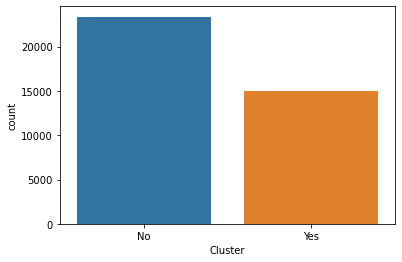

In [150]:
# Predict the Cluster Labels
HD_train_pred = clf.predict(GH_train)

# Append Labels to the Data
GH_train_labeled = GH_train.copy()
GH_train_labeled["Cluster"] = pd.Categorical(HD_train_pred)

# Summary of the Cluster Labels
sb.countplot(x=GH_train_labeled["Cluster"])

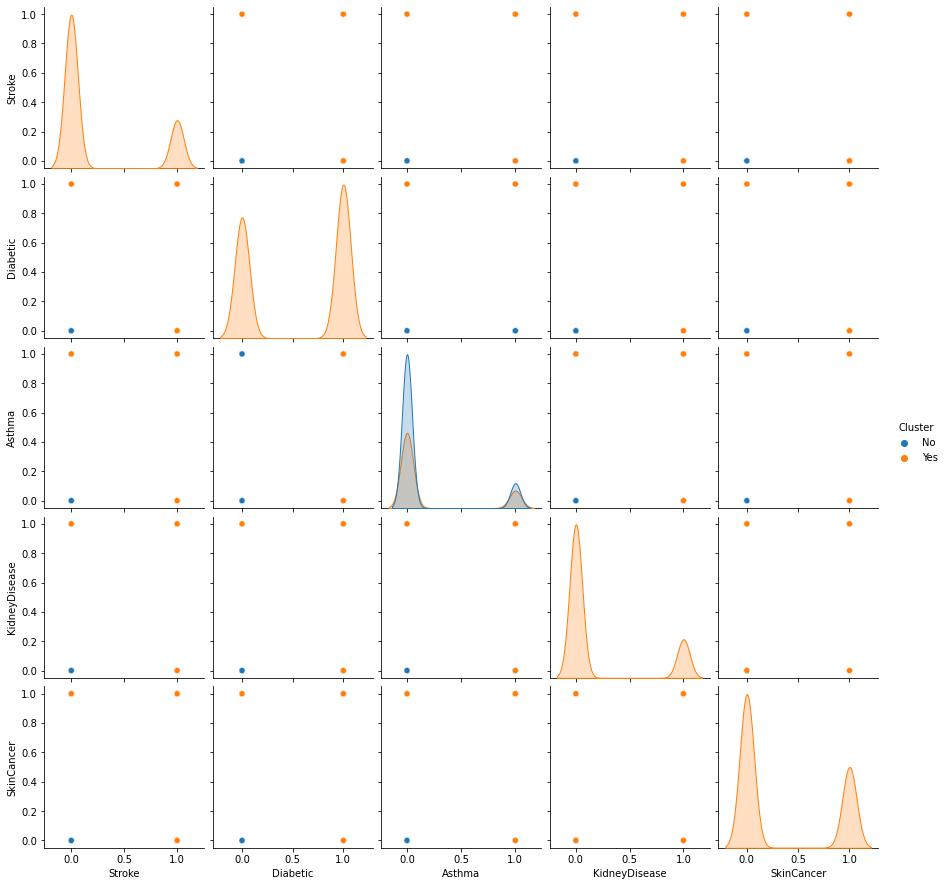

In [151]:
# Plot the Clusters on 2D grids
sb.pairplot(GH_train_labeled, vars = GH_train.columns.values, hue = "Cluster")

Classification Accuracy 	: 0.6734656600097418


Text(33.0, 0.5, 'True Value')

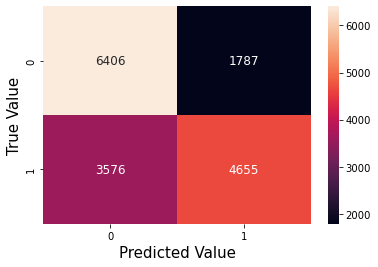

In [152]:
HD_test_pred = clf.predict(GH_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", clf.score(GH_test, HD_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_test, HD_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [153]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
kkLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
kkLS_Spec = TN / float(TN+FP)
#Precision
kkLS_Prec = TP/ float(TP+FP)
# Accuracy
kkLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
kkLS_f = 2*((kkLS_Sen*kkLS_Prec)/(kkLS_Prec+kkLS_Sen))
#False Positive Rate
kkLS_FPR = FP/ float(TN+FP)
#False Negative Rate
kkLS_FNR = FN/ float(TP+FN)

kkLS_result2 = [kkLS_Sen,kkLS_Spec,kkLS_Prec,kkLS_Acc,kkLS_f,kkLS_FPR,kkLS_FNR]

kk2_Test_result = {'Algorithm ': ['K-Nearest Neighbour'],'Sensitivity ': [kkLS_Sen], 'Specificity': [kkLS_Spec],'Precision ': [kkLS_Prec],'Accuracy': [kkLS_Acc], 'F-score': [kkLS_f],'FPR ': [kkLS_FPR], 'FNR': [kkLS_FNR]}
kk2_Test_bal = pd.DataFrame(kk2_Test_result)
kk2_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  K-Nearest Neighbour      0.565545     0.781887    0.722602  0.673466   

    F-score      FPR        FNR  
0  0.634499  0.218113  0.434455

# Logistic Regression

In [154]:
GH_train, GH_test, HD_train, HD_test = train_test_split(Lifestyle_bal, y_res, train_size=0.7, test_size=0.3, random_state=100)
reg = LogisticRegression()
reg.fit(GH_train, HD_train)
HD_train_pred = reg.predict(GH_train)
print("Accuracy on training set: {:.3f}".format(reg.score(GH_train, HD_train))) 
print("Accuracy on test set: {:.3f}".format(reg.score(GH_test, HD_test)))

Accuracy on training set: 0.612
Accuracy on test set: 0.603


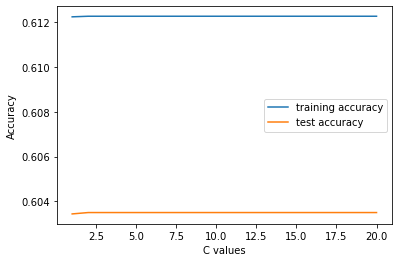

In [155]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 21) 
for var in neighbors_settings: # build the model 
    reg = LogisticRegression(C = var) 
    reg.fit(GH_train, HD_train) # record training set accuracy 
    training_accuracy.append(reg.score(GH_train, HD_train)) # record generalization accuracy 
    test_accuracy.append(reg.score(GH_test, HD_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("C values") 
plt.legend()

Classification Accuracy 	: 0.6122592766557069


Text(33.0, 0.5, 'True Value')

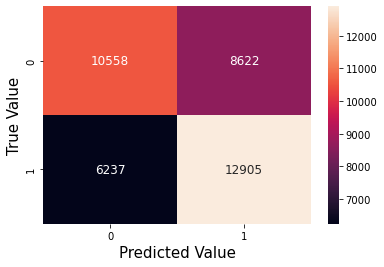

In [156]:
reg.fit(GH_train, HD_train)
HD_train_pred = reg.predict(GH_train)
# Print the Classification Accuracy
print("Classification Accuracy \t:", reg.score(GH_train, HD_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_train, HD_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.6035070628348758


Text(33.0, 0.5, 'True Value')

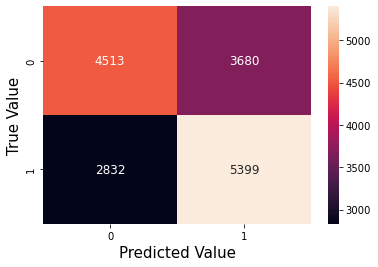

In [157]:
HD_test_pred = reg.predict(GH_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", reg.score(GH_test, HD_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(HD_test, HD_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [158]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
lgLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
lgLS_Spec = TN / float(TN+FP)
#Precision
lgLS_Prec = TP/ float(TP+FP)
# Accuracy
lgLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
lgLS_f = 2*((lgLS_Sen*lgLS_Prec)/(lgLS_Prec+lgLS_Sen))
#False Positive Rate
lgLS_FPR = FP/ float(TN+FP)
#False Negative Rate
lgLS_FNR = FN/ float(TP+FN)

lgLS_result2 = [lgLS_Sen,lgLS_Spec,lgLS_Prec,lgLS_Acc,lgLS_f,lgLS_FPR,lgLS_FNR]

lg2_Test_result = {'Algorithm ': ['Logistic Regression'],'Sensitivity ': [lgLS_Sen], 'Specificity': [lgLS_Spec],'Precision ': [lgLS_Prec],'Accuracy': [lgLS_Acc], 'F-score': [lgLS_f],'FPR ': [lgLS_FPR], 'FNR': [lgLS_FNR]}
lg2_Test_bal = pd.DataFrame(lg2_Test_result)
lg2_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  Logistic Regression      0.655935     0.550836    0.594669  0.603507   

    F-score      FPR        FNR  
0  0.623801  0.449164  0.344065

# Algorithm performance

In [159]:
Balance_result2 = pd.concat([DT2_Test_bal,RF2_Test_bal,GB2_Test_bal,kk2_Test_bal, lg2_Test_bal], axis = 0)
Balance_result2

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0        Decision Tree      0.529097     0.796412    0.723062  0.662445   
0        Random Forest      0.565545     0.781887    0.722602  0.673466   
0     Gradient Boosted      0.565545     0.781887    0.722602  0.673466   
0  K-Nearest Neighbour      0.565545     0.781887    0.722602  0.673466   
0  Logistic Regression      0.655935     0.550836    0.594669  0.603507   

    F-score      FPR        FNR  
0  0.611057  0.203588  0.470903  
0  0.634499  0.218113  0.434455  
0  0.634499  0.218113  0.434455  
0  0.634499  0.218113  0.434455  
0  0.623801  0.449164  0.344065

For General health dataset, the Logistic gave the best results with a better accuracy and FNR

# Comparing General Health and Lifestyle Habits as a predictor of heart disease

For Lifestyle data,

In [160]:
Balance_result

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0        Decision Tree      0.667355     0.538753    0.592429  0.603203   
0        Random Forest      0.653991     0.566337    0.602395  0.610265   
0     Gradient Boosted      0.629207     0.586354    0.604458  0.607830   
0  K-Nearest Neighbour      0.608432     0.581960    0.593857  0.595226   
0  Logistic Regression      0.655935     0.550836    0.594669  0.603507   

    F-score      FPR        FNR  
0  0.627664  0.461247  0.332645  
0  0.627133  0.433663  0.346009  
0  0.616584  0.413646  0.370793  
0  0.601056  0.418040  0.391568  
0  0.623801  0.449164  0.344065

For General health data,

In [161]:
Balance_result2

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0        Decision Tree      0.529097     0.796412    0.723062  0.662445   
0        Random Forest      0.565545     0.781887    0.722602  0.673466   
0     Gradient Boosted      0.565545     0.781887    0.722602  0.673466   
0  K-Nearest Neighbour      0.565545     0.781887    0.722602  0.673466   
0  Logistic Regression      0.655935     0.550836    0.594669  0.603507   

    F-score      FPR        FNR  
0  0.611057  0.203588  0.470903  
0  0.634499  0.218113  0.434455  
0  0.634499  0.218113  0.434455  
0  0.634499  0.218113  0.434455  
0  0.623801  0.449164  0.344065

Comparing both, as the accuracy values are relatively close to one another, we decided to compare the FNR of the algorithm. From this, in general, Lifestyle data gave a lower FNR however it give a very high FPR. Thus, both datasets alone are not good predictor for heart disease

# Minimum Features

Now we wish to know which features are the most important in predicting the likelihood of having heart disease. First we have to determine the most suitable model for the entire dataset

In [162]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, train_size=0.7, test_size=0.3, random_state=100)
print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (38322, 1) (38322, 39)
Test Set  : (16424, 1) (16424, 39)


# Decision Tree

In [163]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
dectree = DecisionTreeClassifier()
dectree.fit(X_train, Y_train)

print("Accuracy on training set: {:.3f}".format(dectree.score(X_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(dectree.score(X_test, Y_test)))

Accuracy on training set: 0.998
Accuracy on test set: 0.669


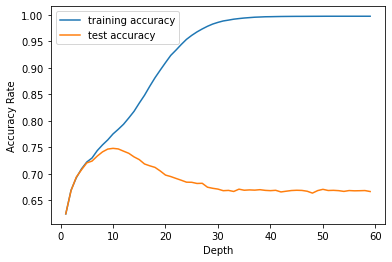

In [164]:
train_acc = [] 
test_acc = [] 
# try n_neighbors from 1 to 10 
x_range = range(1,60)
for var in x_range:
    dectree = DecisionTreeClassifier(max_depth = var)
    dectree.fit(X_train, Y_train)
    train_scr = dectree.score(X_train, Y_train)
    test_scr = dectree.score(X_test, Y_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)
    

plt.plot(x_range, train_acc, label="training accuracy") 
plt.plot(x_range, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Depth") 
plt.legend()

In [165]:
# Train the Decision Tree Classifier model
dectree = DecisionTreeClassifier(max_depth = 10)
dectree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=10)

In [166]:
dectree.fit(X_train, Y_train) 
Tree_acc = dectree.score(X_test, Y_test)
Tree_acc_t = dectree.score(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(dectree.score(X_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(dectree.score(X_test, Y_test)))

Accuracy on training set: 0.776
Accuracy on test set: 0.749


Depth above 10 starts to exhibit overfitting

# Random Forest Classifier

In [167]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, Y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, Y_test)))

Accuracy on training set: 0.998
Accuracy on test set: 0.739


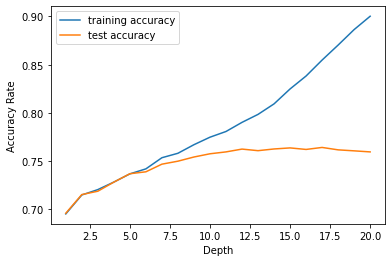

In [168]:
train_acc = [] 
test_acc = [] 
# try n_neighbors from 1 to 10 
x_range = range(1,21,1)
for var in x_range:
    gbrt = RandomForestClassifier(max_depth = var)
    gbrt.fit(X_train, Y_train)
    train_scr = gbrt.score(X_train, Y_train)
    test_scr = gbrt.score(X_test, Y_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)
    

plt.plot(x_range, train_acc, label="training accuracy") 
plt.plot(x_range, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Depth") 
plt.legend()

In [169]:
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
pipe = Pipeline([("classifier", RandomForestClassifier())])

search_space = [{"classifier": [RandomForestClassifier()], "classifier__max_features": [1, 2, 3], "classifier__max_depth": [5, 10, 15]}]
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)
best_model = gridsearch.fit(X_train, Y_train)
best_model.best_estimator_.get_params()["classifier"]

RandomForestClassifier(max_depth=15, max_features=1)

In [170]:
forest = best_model.best_estimator_.get_params()["classifier"]
forest.fit(X_train, Y_train)
forest_acc = forest.score(X_test, Y_test)
forest_acc_t = forest.score(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, Y_test)))

Accuracy on training set: 0.820
Accuracy on test set: 0.758


# Gradient boosted regression trees

In [171]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0) 
gbrt.fit(X_train, Y_train) 
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, Y_test)))

Accuracy on training set: 0.768
Accuracy on test set: 0.766


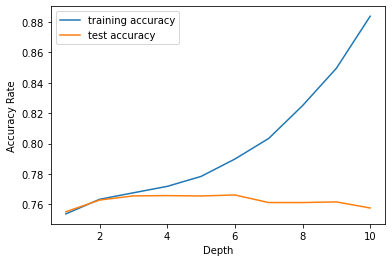

In [172]:
train_acc = [] 
test_acc = [] 
# try n_neighbors from 1 to 10 
x_range = range(1,11)
for var in x_range:
    gbrt = GradientBoostingClassifier(max_depth = var)
    gbrt.fit(X_train, Y_train)
    train_scr = gbrt.score(X_train, Y_train)
    test_scr = gbrt.score(X_test, Y_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)

plt.plot(x_range, train_acc, label="training accuracy") 
plt.plot(x_range, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Depth") 
plt.legend()

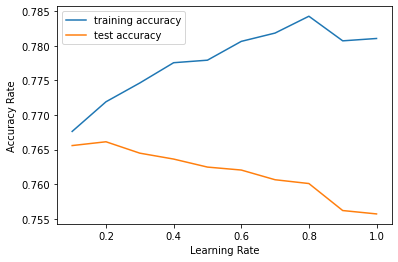

In [173]:
train_acc = [] 
test_acc = [] 
x_axis = []
# try n_neighbors from 1 to 10 
x_range = range(1,11,1)
for var in x_range:
    gbrt = GradientBoostingClassifier(learning_rate = var/10)
    gbrt.fit(X_train, Y_train)
    train_scr = gbrt.score(X_train, Y_train)
    test_scr = gbrt.score(X_test, Y_test)
    train_acc.append(train_scr)
    test_acc.append(test_scr)
    x_axis.append(var/10)

plt.plot(x_axis, train_acc, label="training accuracy") 
plt.plot(x_axis, test_acc, label="test accuracy") 
plt.ylabel("Accuracy Rate") 
plt.xlabel("Learning Rate") 
plt.legend()

In [174]:
pipe = Pipeline([("classifier", GradientBoostingClassifier())])

search_space = [{"classifier": [GradientBoostingClassifier()], "classifier__learning_rate": [0.1, 0.2, 0.4], "classifier__max_depth": [2, 3, 4]}]
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)
best_model = gridsearch.fit(X_train, Y_train)
best_model.best_estimator_.get_params()["classifier"]

GradientBoostingClassifier(learning_rate=0.2)

In [175]:
gbrt = best_model.best_estimator_.get_params()["classifier"]
gbrt.fit(X_train, Y_train) 
gbrt_acc = gbrt.score(X_test, Y_test)
gbrt_acc_t = gbrt.score(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, Y_test)))

Accuracy on training set: 0.772
Accuracy on test set: 0.766


# k-Nearest Neighbors

In [176]:
from sklearn.neighbors import KNeighborsClassifier 
clf = KNeighborsClassifier() 

In [177]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaler.fit(X_train)

cols = X_train.columns
Xk_train = pd.DataFrame(scaler.transform(X_train))
Xk_train.columns = cols

cols = X_test.columns
Xk_test = pd.DataFrame(scaler.transform(X_test))
Xk_test.columns = cols

In [178]:
Xk_train

BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0      0.137597      0.0              0.0     0.0        0.000000   
1      0.221346      1.0              0.0     0.0        0.000000   
2      0.205703      0.0              0.0     0.0        0.000000   
3      0.226883      1.0              0.0     0.0        0.000000   
4      0.293051      0.0              0.0     0.0        0.000000   
...         ...      ...              ...     ...             ...   
38317  0.088594      1.0              0.0     0.0        0.333333   
38318  0.206534      1.0              0.0     0.0        0.000000   
38319  0.261489      1.0              0.0     0.0        0.000000   
38320  0.293189      0.0              0.0     0.0        0.166667   
38321  0.188538      0.0              0.0     1.0        0.000000   

       MentalHealth  DiffWalking  Diabetic  PhysicalActivity  SleepTime  ...  \
0          0.000000          0.0       0.0               1.0   0.304348  ...   
1          0.000000          0.0       0.0               1.0   0.260870  ...   
2          0.333333          1.0       0.0               0.0   0.391304  ...   
3          0.000000          0.0       0.0               1.0   0.304348  ...   
4          0.033333          0.0       1.0               1.0   0.304348  ...   
...             ...          ...       ...               ...        ...  ...   
38317      0.000000          0.0       0.0               1.0   0.304348  ...   
38318      0.000000          0.0       0.0               1.0   0.304348  ...   
38319      0.000000          0.0       0.0               1.0   0.260870  ...   
38320      0.000000          0.0       0.0               1.0   0.347826  ...   
38321      1.000000          0.0       1.0               1.0   0.173913  ...   

       Race_Asian  Race_Black  Race_Hispanic  Race_Other  Race_White  \
0             0.0         0.0            0.0         0.0         1.0   
1             0.0         0.0            0.0         0.0         1.0   
2             0.0         0.0            0.0         0.0         1.0   
3             0.0         0.0            0.0         0.0         1.0   
4             0.0         0.0            0.0         0.0         1.0   
...           ...         ...            ...         ...         ...   
38317         0.0         0.0            0.0         0.0         1.0   
38318         0.0         0.0            0.0         0.0         1.0   
38319         0.0         0.0            0.0         0.0         1.0   
38320         0.0         0.0            0.0         0.0         1.0   
38321         0.0         0.0            0.0         0.0         1.0   

       GenHealth_Excellent  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
0                      0.0             0.0             0.0             0.0   
1                      1.0             0.0             0.0             0.0   
2                      0.0             0.0             0.0             0.0   
3                      0.0             0.0             1.0             0.0   
4                      0.0             0.0             1.0             0.0   
...                    ...             ...             ...             ...   
38317                  0.0             0.0             0.0             0.0   
38318                  1.0             0.0             0.0             0.0   
38319                  0.0             0.0             1.0             0.0   
38320                  0.0             0.0             0.0             0.0   
38321                  0.0             1.0             0.0             0.0   

       GenHealth_Very good  
0                      1.0  
1                      0.0  
2                      1.0  
3                      0.0  
4                      0.0  
...                    ...  
38317                  1.0  
38318                  0.0  
38319                  0.0  
38320                  1.0  
38321                  0.0  

[38322 rows x 39 columns]

In [179]:
Xk_test

BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0      0.525748      0.0              0.0     0.0        0.333333   
1      0.236573      1.0              0.0     0.0        0.500000   
2      0.107143      1.0              0.0     0.0        0.666667   
3      0.142027      0.0              0.0     0.0        0.000000   
4      0.158223      1.0              0.0     0.0        0.000000   
...         ...      ...              ...     ...             ...   
16419  0.243079      0.0              0.0     0.0        0.000000   
16420  0.427326      1.0              0.0     0.0        0.833333   
16421  0.138981      0.0              0.0     0.0        0.100000   
16422  0.187846      1.0              0.0     0.0        0.000000   
16423  0.325720      1.0              0.0     0.0        0.100000   

       MentalHealth  DiffWalking  Diabetic  PhysicalActivity  SleepTime  ...  \
0          0.066667          0.0       0.0               1.0   0.217391  ...   
1          0.000000          0.0       0.0               0.0   0.217391  ...   
2          0.000000          0.0       0.0               1.0   0.304348  ...   
3          0.000000          0.0       1.0               1.0   0.304348  ...   
4          0.100000          1.0       0.0               0.0   0.304348  ...   
...             ...          ...       ...               ...        ...  ...   
16419      0.000000          0.0       0.0               1.0   0.304348  ...   
16420      0.033333          1.0       0.0               0.0   0.086957  ...   
16421      0.166667          0.0       0.0               1.0   0.260870  ...   
16422      0.000000          0.0       0.0               1.0   0.304348  ...   
16423      0.000000          0.0       0.0               1.0   0.304348  ...   

       Race_Asian  Race_Black  Race_Hispanic  Race_Other  Race_White  \
0             0.0         0.0            0.0         0.0         1.0   
1             0.0         0.0            0.0         0.0         1.0   
2             0.0         0.0            0.0         0.0         1.0   
3             0.0         0.0            0.0         0.0         1.0   
4             0.0         0.0            0.0         0.0         1.0   
...           ...         ...            ...         ...         ...   
16419         0.0         0.0            1.0         0.0         0.0   
16420         0.0         0.0            0.0         0.0         0.0   
16421         0.0         0.0            0.0         0.0         1.0   
16422         0.0         0.0            0.0         0.0         1.0   
16423         0.0         0.0            0.0         0.0         1.0   

       GenHealth_Excellent  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
0                      0.0             1.0             0.0             0.0   
1                      0.0             1.0             0.0             0.0   
2                      0.0             0.0             0.0             1.0   
3                      0.0             0.0             1.0             0.0   
4                      0.0             0.0             0.0             0.0   
...                    ...             ...             ...             ...   
16419                  0.0             0.0             0.0             0.0   
16420                  0.0             1.0             0.0             0.0   
16421                  0.0             0.0             0.0             0.0   
16422                  0.0             0.0             1.0             0.0   
16423                  0.0             0.0             0.0             0.0   

       GenHealth_Very good  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      1.0  
...                    ...  
16419                  1.0  
16420                  0.0  
16421                  1.0  
16422                  0.0  
16423                  1.0  

[16424 rows x 39 columns]

In [180]:
clf = KNeighborsClassifier() 
clf.fit(Xk_train, Y_train) 
print("Accuracy on training set: {:.3f}".format(clf.score(Xk_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(clf.score(Xk_test, Y_test)))

Accuracy on training set: 0.806
Accuracy on test set: 0.728


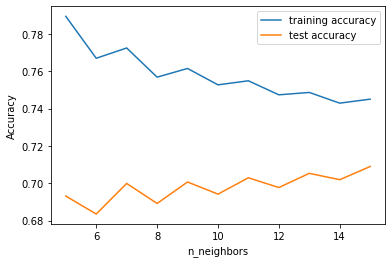

In [181]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(5, 16) 
for n_neighbors in neighbors_settings: # build the model 
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(X_train, Y_train) # record training set accuracy 
    training_accuracy.append(clf.score(X_train, Y_train)) # record generalization accuracy 
    test_accuracy.append(clf.score(X_test, Y_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("n_neighbors") 
plt.legend()

In [182]:
clf = KNeighborsClassifier(n_neighbors = 15) 
clf.fit(X_train, Y_train) 
clf_acc = clf.score(X_test, Y_test)
clf_acc_t = clf.score(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(clf.score(X_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(clf.score(X_test, Y_test)))

Accuracy on training set: 0.745
Accuracy on test set: 0.709


Test accuracy stay around 0.71 despite higher neighbours and significant run time

# Logistic Regression

In [183]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()

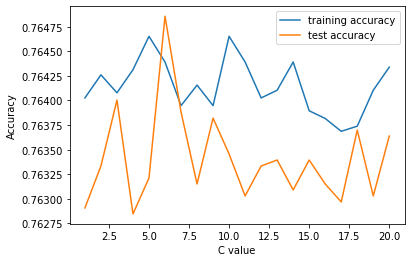

In [184]:
training_accuracy = [] 
test_accuracy = [] 
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 21) 
for var in neighbors_settings: # build the model 
    reg = LogisticRegression(C = var) 
    reg.fit(X_train, Y_train) # record training set accuracy 
    training_accuracy.append(reg.score(X_train, Y_train)) # record generalization accuracy 
    test_accuracy.append(reg.score(X_test, Y_test)) 

plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy") 
plt.xlabel("C value") 
plt.legend()

In [185]:
pipe = Pipeline([("classifier", LogisticRegression())])

search_space = [{"classifier": [LogisticRegression()], "classifier__C": [8, 9, 18]}]
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)
best_model = gridsearch.fit(X_train, Y_train)
best_model.best_estimator_.get_params()["classifier"]

LogisticRegression(C=18)

In [186]:
reg = best_model.best_estimator_.get_params()["classifier"]
reg.fit(X_train, Y_train) 
reg_acc = reg.score(X_test, Y_test)
reg_acc_t = reg.score(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(reg.score(X_train, Y_train))) 
print("Accuracy on test set: {:.3f}".format(reg.score(X_test, Y_test)))

Accuracy on training set: 0.764
Accuracy on test set: 0.764


# Algorithm assessment

In [187]:
Train_results = {'Algorithm ': ['Accuracy'],'Decision Tree': [Tree_acc_t], 'Random Forest': [forest_acc_t],'Gradient Boosted ': [gbrt_acc_t],'K-Nearest': [clf_acc_t], 'Logistic': [reg_acc_t]}
Train_results = pd.DataFrame(Train_results)
Train_results

Algorithm   Decision Tree  Random Forest  Gradient Boosted   K-Nearest  \
0   Accuracy       0.775534       0.819686           0.771906   0.745133   

   Logistic  
0  0.763739

In [188]:
Test_results = {'Algorithm ': ['Accuracy'],'Decision Tree': [Tree_acc], 'Random Forest': [forest_acc],'Gradient Boosted ': [gbrt_acc],'K-Nearest': [clf_acc], 'Logistic': [reg_acc]}
Test_results = pd.DataFrame(Test_results)
Test_results

Algorithm   Decision Tree  Random Forest  Gradient Boosted   K-Nearest  \
0   Accuracy        0.74866       0.758098           0.766135   0.709023   

   Logistic  
0  0.763699

Gradient boosted regression tree and Logistic Regression displayed a better test accuracy without overfitting

# Evaluate the two models

# Gradient Boosted

Classification Accuracy 	: 0.7719064766974584


Text(33.0, 0.5, 'True Value')

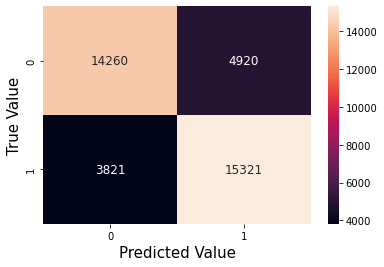

In [189]:
gbrt.fit(X_train, Y_train) 
GB_X_train_pred = gbrt.predict(X_train)
# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(X_train, Y_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_train, GB_X_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.7661349245007306


Text(33.0, 0.5, 'True Value')

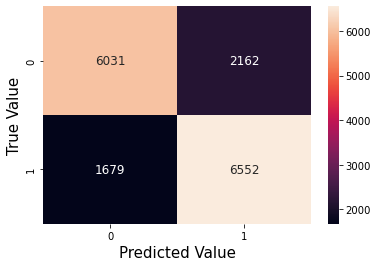

In [190]:
GB_X_test_pred = gbrt.predict(X_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(X_test, Y_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test, GB_X_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [191]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
GBLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
GBLS_Spec = TN / float(TN+FP)
#Precision
GBLS_Prec = TP/ float(TP+FP)
# Accuracy
GBLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
GBLS_f = 2*((GBLS_Sen*GBLS_Prec)/(GBLS_Prec+GBLS_Sen))
#False Positive Rate
GBLS_FPR = FP/ float(TN+FP)
#False Negative Rate
GBLS_FNR = FN/ float(TP+FN)

GB3_Test_result = {'Algorithm ': ['Gradient Boosted'],'Sensitivity ': [GBLS_Sen], 'Specificity': [GBLS_Spec],'Precision ': [GBLS_Prec],'Accuracy': [GBLS_Acc], 'F-score': [GBLS_f],'FPR ': [GBLS_FPR], 'FNR': [GBLS_FNR]}
GB3_Test_bal = pd.DataFrame(GB3_Test_result)
GB3_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  Gradient Boosted      0.796015     0.736116    0.751894  0.766135   

    F-score      FPR        FNR  
0  0.773325  0.263884  0.203985

# Logistic Regression

Classification Accuracy 	: 0.7637388445279474


Text(33.0, 0.5, 'True Value')

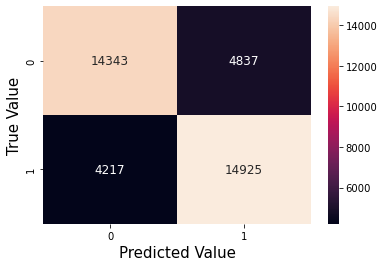

In [192]:
reg.fit(X_train, Y_train)
reg_X_train_pred = reg.predict(X_train)
# Print the Classification Accuracy
print("Classification Accuracy \t:", reg.score(X_train, Y_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_train, reg_X_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.7636994641987336


Text(33.0, 0.5, 'True Value')

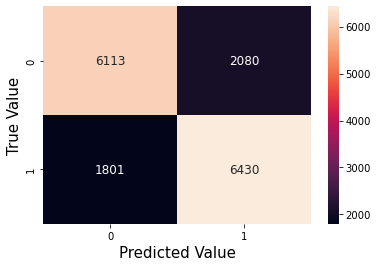

In [193]:
reg_X_test_pred = reg.predict(X_test)

# Print the Classification Accuracy
print("Classification Accuracy \t:", reg.score(X_test, Y_test))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test, reg_X_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [194]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity/Recall of our logistic regression model
lgLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
lgLS_Spec = TN / float(TN+FP)
#Precision
lgLS_Prec = TP/ float(TP+FP)
# Accuracy
lgLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
lgLS_f = 2*((lgLS_Sen*lgLS_Prec)/(lgLS_Prec+lgLS_Sen))
#False Positive Rate
lgLS_FPR = FP/ float(TN+FP)
#False Negative Rate
lgLS_FNR = FN/ float(TP+FN)

lg3_Test_result = {'Algorithm ': ['Logistic Regression'],'Sensitivity ': [lgLS_Sen], 'Specificity': [lgLS_Spec],'Precision ': [lgLS_Prec],'Accuracy': [lgLS_Acc], 'F-score': [lgLS_f],'FPR ': [lgLS_FPR], 'FNR': [lgLS_FNR]}
lg3_Test_bal = pd.DataFrame(lg3_Test_result)
lg3_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  Logistic Regression      0.781193     0.746125    0.755582  0.763699   

    F-score      FPR        FNR  
0  0.768174  0.253875  0.218807

# Comparing results

In [195]:
Data_result = pd.concat([GB3_Test_bal,lg3_Test_bal], axis = 0)
Data_result

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0     Gradient Boosted      0.796015     0.736116    0.751894  0.766135   
0  Logistic Regression      0.781193     0.746125    0.755582  0.763699   

    F-score      FPR        FNR  
0  0.773325  0.263884  0.203985  
0  0.768174  0.253875  0.218807

The Gradient Boosted algorithm provided a lower FNR and higher F-Score, thus it is a better model

# Minimum Features needed

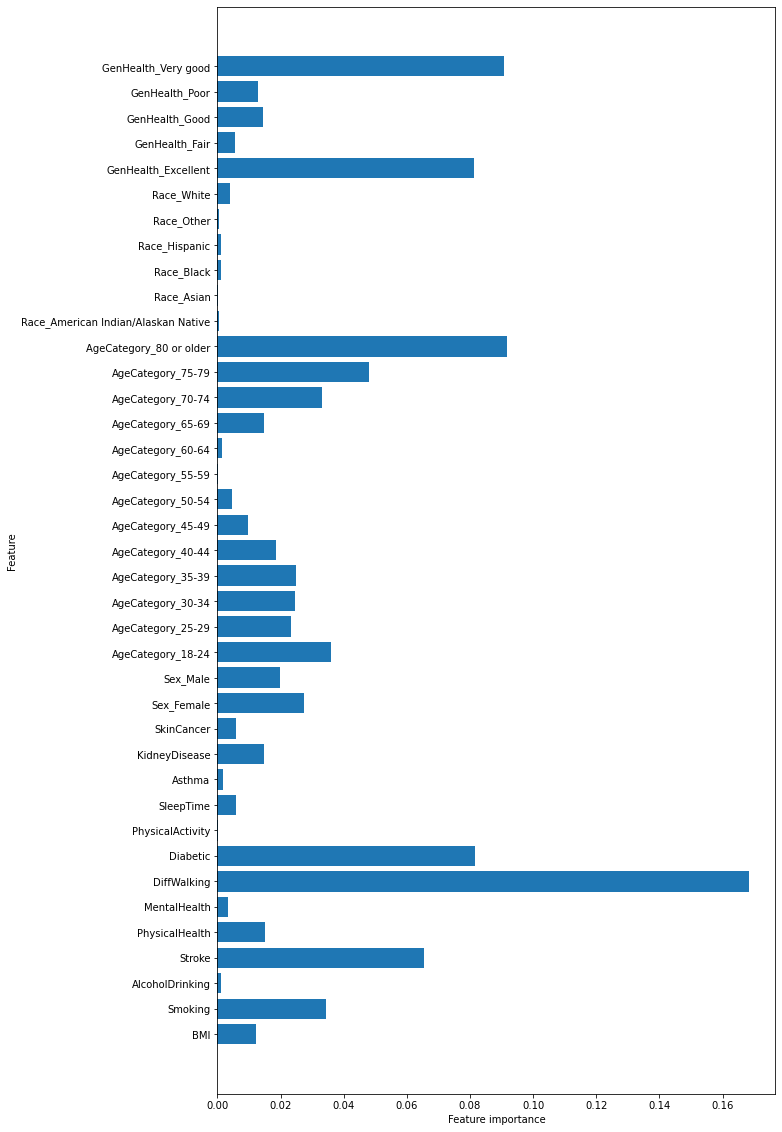

In [196]:
plt.figure(figsize=(10,20))
def plot_feature_importances_hd(model): 
    n_features = X_res.shape[1] 
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_res.columns) 
    plt.xlabel("Feature importance") 
    plt.ylabel("Feature") 
plot_feature_importances_hd(gbrt)

In [197]:
from sklearn.ensemble import GradientBoostingClassifier

Visualizing the feature importance in Grandient boosting classifier, we noticed that some features are not siginificantly important in prediciting the outcome. 
However, adding more features makes all models more complex, and so increases the chance of overfitting. When adding new features, or with high-dimensional datasets in general, it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest. This can lead to simpler models that generalize better.

Introduction to Machine Learning with Python: A Guide for Data Scientists - (Page 236). 

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

# Model-Based Feature Selection


In [226]:
from sklearn.feature_selection import SelectFromModel 
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, train_size=0.7, test_size=0.3, random_state=100)
select = SelectFromModel(GradientBoostingClassifier(learning_rate=0.2), max_features=31,threshold=-np.inf)

In [227]:
select.fit(X_train, Y_train) 
X_train_l1 = select.transform(X_train) 
print("X_train.shape: {}".format(X_train.shape)) 
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (38322, 39)
X_train_l1.shape: (38322, 31)


In [228]:
SFS_cols = select.get_feature_names_out()
SFS_cols

array(['BMI', 'Smoking', 'Stroke', 'PhysicalHealth', 'MentalHealth',
       'DiffWalking', 'Diabetic', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Sex_Female', 'Sex_Male', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_White',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good'], dtype=object)

In [229]:
SFS_cols.size

31

In [230]:
X_test_l1 = select.transform(X_test) 
score = gbrt.fit(X_train_l1, Y_train).score(X_test_l1, Y_test) 
print("Test score: {:.3f}".format(score))

Test score: 0.766


In [231]:
# Creating X_train dataframe with RFE selected variables
X_train_sfs = X_train[SFS_cols]
X_test_sfs = X_test[SFS_cols]
X_train_sfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38322 entries, 49534 to 38408
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BMI                      38322 non-null  float64
 1   Smoking                  38322 non-null  int64  
 2   Stroke                   38322 non-null  int64  
 3   PhysicalHealth           38322 non-null  float64
 4   MentalHealth             38322 non-null  float64
 5   DiffWalking              38322 non-null  int64  
 6   Diabetic                 38322 non-null  int64  
 7   SleepTime                38322 non-null  float64
 8   Asthma                   38322 non-null  int64  
 9   KidneyDisease            38322 non-null  int64  
 10  SkinCancer               38322 non-null  int64  
 11  Sex_Female               38322 non-null  uint8  
 12  Sex_Male                 38322 non-null  uint8  
 13  AgeCategory_18-24        38322 non-null  uint8  
 14  AgeCategory_25-29 

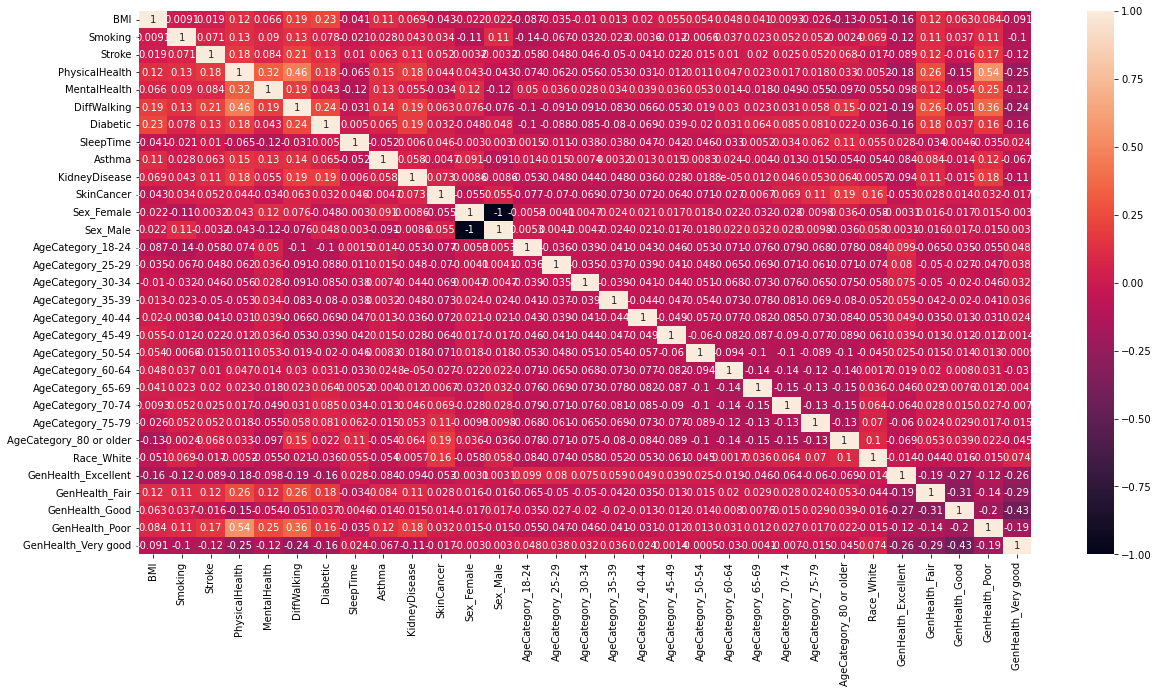

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,10))
sb.heatmap(X_train_sfs.corr(),annot = True)
plt.show()

In [233]:
gbrt.fit(X_train_sfs, Y_train)
Y_train_pred = gbrt.predict(X_train_sfs)
Y_train_pred

array(['No', 'No', 'Yes', ..., 'Yes', 'No', 'Yes'], dtype=object)

Classification Accuracy 	: 0.7701059443661604


Text(33.0, 0.5, 'True Value')

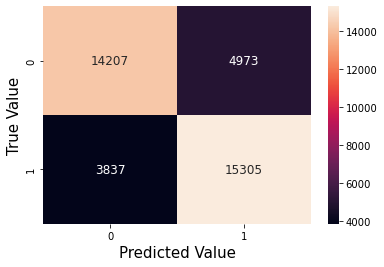

In [234]:
# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(X_train_sfs, Y_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_train, Y_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.7660740379931807


Text(33.0, 0.5, 'True Value')

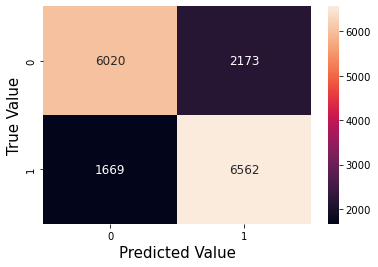

In [235]:
# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(X_test_sfs, Y_test))

Y_test_pred = gbrt.predict(X_test_sfs)
# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test, Y_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [236]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
GBLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
GBLS_Spec = TN / float(TN+FP)
#Precision
GBLS_Prec = TP/ float(TP+FP)
# Accuracy
GBLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
GBLS_f = 2*((GBLS_Sen*GBLS_Prec)/(GBLS_Prec+GBLS_Sen))
#False Positive Rate
GBLS_FPR = FP/ float(TN+FP)
#False Negative Rate
GBLS_FNR = FN/ float(TP+FN)

GB4_Test_result = {'Algorithm ': ['Model Selection'],'Sensitivity ': [GBLS_Sen], 'Specificity': [GBLS_Spec],'Precision ': [GBLS_Prec],'Accuracy': [GBLS_Acc], 'F-score': [GBLS_f],'FPR ': [GBLS_FPR], 'FNR': [GBLS_FNR]}
GB4_Test_bal = pd.DataFrame(GB4_Test_result)
GB4_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy   F-score  \
0  Model Selection       0.79723     0.734774    0.751231  0.766074  0.773547   

       FPR       FNR  
0  0.265226  0.20277

# Recursive Feature Elimination

In [237]:
gbrt = GradientBoostingClassifier(learning_rate = 0.2) 
from sklearn.feature_selection import RFE
rfe = RFE(gbrt,n_features_to_select=SFS_cols.size)             # running RFE
rfe = rfe.fit(X_train, Y_train)

In [238]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('BMI', True, 1),
 ('Smoking', True, 1),
 ('AlcoholDrinking', True, 1),
 ('Stroke', True, 1),
 ('PhysicalHealth', True, 1),
 ('MentalHealth', True, 1),
 ('DiffWalking', True, 1),
 ('Diabetic', True, 1),
 ('PhysicalActivity', False, 8),
 ('SleepTime', True, 1),
 ('Asthma', True, 1),
 ('KidneyDisease', True, 1),
 ('SkinCancer', True, 1),
 ('Sex_Female', True, 1),
 ('Sex_Male', True, 1),
 ('AgeCategory_18-24', True, 1),
 ('AgeCategory_25-29', True, 1),
 ('AgeCategory_30-34', True, 1),
 ('AgeCategory_35-39', True, 1),
 ('AgeCategory_40-44', True, 1),
 ('AgeCategory_45-49', True, 1),
 ('AgeCategory_50-54', True, 1),
 ('AgeCategory_55-59', False, 9),
 ('AgeCategory_60-64', False, 2),
 ('AgeCategory_65-69', True, 1),
 ('AgeCategory_70-74', True, 1),
 ('AgeCategory_75-79', True, 1),
 ('AgeCategory_80 or older', True, 1),
 ('Race_American Indian/Alaskan Native', False, 5),
 ('Race_Asian', False, 6),
 ('Race_Black', False, 3),
 ('Race_Hispanic', False, 4),
 ('Race_Other', False, 7),
 ('Race_Whi

In [239]:
rfe_columns = X_train.columns[rfe.support_]
rfe_columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Diabetic', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Sex_Female', 'Sex_Male',
       'AgeCategory_18-24', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_45-49',
       'AgeCategory_50-54', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_White',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good'],
      dtype='object')

In [240]:
# Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train[rfe_columns]
X_test_rfe = X_test[rfe_columns]
X_train_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38322 entries, 49534 to 38408
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BMI                      38322 non-null  float64
 1   Smoking                  38322 non-null  int64  
 2   AlcoholDrinking          38322 non-null  int64  
 3   Stroke                   38322 non-null  int64  
 4   PhysicalHealth           38322 non-null  float64
 5   MentalHealth             38322 non-null  float64
 6   DiffWalking              38322 non-null  int64  
 7   Diabetic                 38322 non-null  int64  
 8   SleepTime                38322 non-null  float64
 9   Asthma                   38322 non-null  int64  
 10  KidneyDisease            38322 non-null  int64  
 11  SkinCancer               38322 non-null  int64  
 12  Sex_Female               38322 non-null  uint8  
 13  Sex_Male                 38322 non-null  uint8  
 14  AgeCategory_18-24 

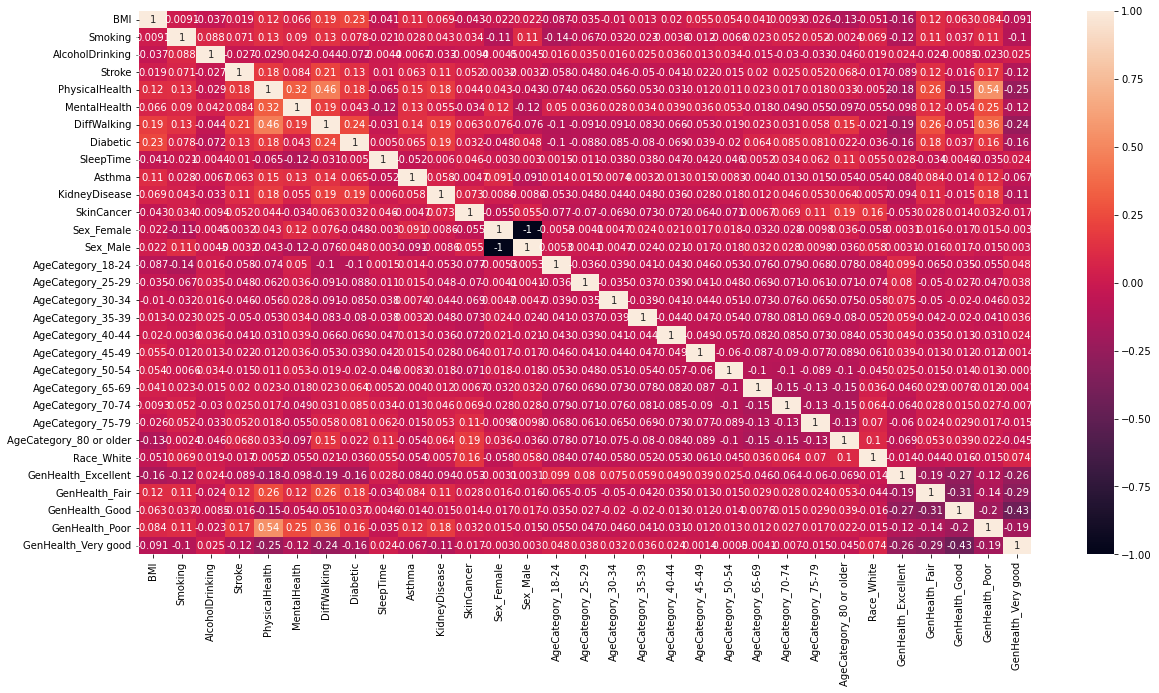

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,10))
sb.heatmap(X_train_rfe.corr(),annot = True)
plt.show()

In [242]:
gbrt.fit(X_train_rfe, Y_train)
Y_train_pred = gbrt.predict(X_train_rfe)
Y_train_pred

array(['No', 'No', 'Yes', ..., 'No', 'No', 'Yes'], dtype=object)

Classification Accuracy 	: 0.7697667136370753


Text(33.0, 0.5, 'True Value')

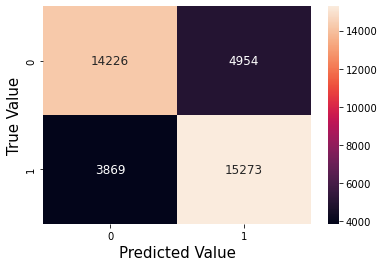

In [243]:
# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(X_train_rfe, Y_train))

# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_train, Y_train_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

Classification Accuracy 	: 0.7660740379931807


Text(33.0, 0.5, 'True Value')

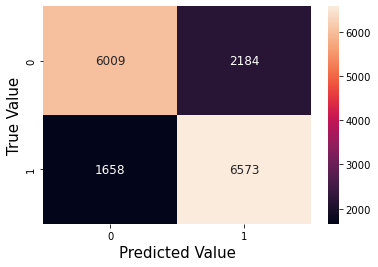

In [244]:
# Print the Classification Accuracy
print("Classification Accuracy \t:", gbrt.score(X_test_rfe, Y_test))

Y_test_pred = gbrt.predict(X_test_rfe)
# Plot the two-way Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test, Y_test_pred)
sb.heatmap(confusion, annot = True, fmt=".0f", annot_kws={"size": 12})
plt.xlabel('Predicted Value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Value', fontsize = 15) # y-axis label with fontsize 15

In [245]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
GBLS_Sen = TP / float(TP+FN)
# Let us calculate specificity
GBLS_Spec = TN / float(TN+FP)
#Precision
GBLS_Prec = TP/ float(TP+FP)
# Accuracy
GBLS_Acc = (TP+TN)/(TP+TN+FP+FN)
# f-score
GBLS_f = 2*((GBLS_Sen*GBLS_Prec)/(GBLS_Prec+GBLS_Sen))
#False Positive Rate
GBLS_FPR = FP/ float(TN+FP)
#False Negative Rate
GBLS_FNR = FN/ float(TP+FN)

GB5_Test_result = {'Algorithm ': ['RFE'],'Sensitivity ': [GBLS_Sen], 'Specificity': [GBLS_Spec],'Precision ': [GBLS_Prec],'Accuracy': [GBLS_Acc], 'F-score': [GBLS_f],'FPR ': [GBLS_FPR], 'FNR': [GBLS_FNR]}
GB5_Test_bal = pd.DataFrame(GB5_Test_result)
GB5_Test_bal

Algorithm   Sensitivity   Specificity  Precision   Accuracy  F-score  \
0        RFE      0.798566     0.733431      0.7506  0.766074  0.77384   

       FPR        FNR  
0  0.266569  0.201434

# Evaluation of feature selection

In [246]:
FS_result = pd.concat([GB3_Test_bal,GB4_Test_bal,GB5_Test_bal], axis = 0)
FS_result

Algorithm   Sensitivity   Specificity  Precision   Accuracy  \
0  Gradient Boosted      0.796015     0.736116    0.751894  0.766135   
0   Model Selection      0.797230     0.734774    0.751231  0.766074   
0               RFE      0.798566     0.733431    0.750600  0.766074   

    F-score      FPR        FNR  
0  0.773325  0.263884  0.203985  
0  0.773547  0.265226  0.202770  
0  0.773840  0.266569  0.201434

From the results, while RFE and Model selection gave a lower accuracy and higher FNR, it was still within a acceptable range accounting for lower feature used. 

In [247]:
rfe_columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Diabetic', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Sex_Female', 'Sex_Male',
       'AgeCategory_18-24', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_45-49',
       'AgeCategory_50-54', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_White',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good'],
      dtype='object')

In [248]:
SFS_cols

array(['BMI', 'Smoking', 'Stroke', 'PhysicalHealth', 'MentalHealth',
       'DiffWalking', 'Diabetic', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Sex_Female', 'Sex_Male', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_White',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good'], dtype=object)

In [249]:
np.array_equal(rfe_columns,SFS_cols)

False

In [250]:
np.setdiff1d(rfe_columns, SFS_cols) #Features used by RFE

array(['AlcoholDrinking'], dtype=object)

In [251]:
np.setdiff1d(SFS_cols, rfe_columns) #Feature used by SelectModel

array(['AgeCategory_60-64'], dtype=object)

These 31 features are suggested as important features in predicting a person likelihood to develope heart disease (30 resulted in the same features being selected, thus no significant usage)

If we were to placed this features back to their categories in the orignal excel sheet, the important features are ['BMI', 'Smoking', 'Stroke', 'PhysicalHealth', 'MentalHealth','DiffWalking', 'Diabetic', 'SleepTime', 'Asthma', 'KidneyDisease','SkinCancer', 'Sex', 'Age', 'GenHealth'] That is 15/17 of the original categories

# Application

In [253]:
LSY = pd.DataFrame({'BMI': [21.8],'Smoking': [0],'AlcoholDrinking': [0],'Stroke': [0], 'PhysicalHealth': [0],'MentalHealth': [0],
                    'DiffWalking': [0],'Diabetic': [0],'SleepTime': [0], 'Asthma': [0], 'KidneyDisease': [0],'SkinCancer': [0],
                    'Sex_Female': [0],
                    'Sex_Male': [1], 'AgeCategory_18-24': [1],'AgeCategory_25-29': [0],'AgeCategory_30-34': [0], 
                    'AgeCategory_35-39': [0],'AgeCategory_40-44': [0],'AgeCategory_45-49': [0], 'AgeCategory_50-54': [0],
                    'AgeCategory_65-69': [0], 'AgeCategory_70-74': [0], 'AgeCategory_75-79': [0],
                    'AgeCategory_80 or older': [0], 'Race_White': [0],'GenHealth_Excellent': [0], 'GenHealth_Fair': [0],
                    'GenHealth_Good': [1],'GenHealth_Poor': [0],'GenHealth_Very good': [0]})
LSY.head()

BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  MentalHealth  \
0  21.8        0                0       0               0             0   

   DiffWalking  Diabetic  SleepTime  Asthma  ...  AgeCategory_65-69  \
0            0         0          0       0  ...                  0   

   AgeCategory_70-74  AgeCategory_75-79  AgeCategory_80 or older  Race_White  \
0                  0                  0                        0           0   

   GenHealth_Excellent  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
0                    0               0               1               0   

   GenHealth_Very good  
0                    0  

[1 rows x 31 columns]

In [254]:
LSY_pred = gbrt.predict(LSY)
LSY_pred

array(['No'], dtype=object)